# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 15

In [2]:
cluster = '15'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 459
Num noneffect sequences: 459


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
358   chr3   49007333   49007334    rs6781790      T         C   C      T   
236  chr19   18438073   18438074    rs2303696    NAN       NAN   T      C   
316   chr2   95057163   95057164     rs872580      C         A   C      A   
405   chr4   89836583   89836584    rs2619361      C         A   C      A   
58   chr15   58758182   58758183    rs2250583      C         T   C      T   
242  chr19   44644418   44644419   rs10426401      T         G   T      G   
315  chr19   45326535   45326536     rs344791      C         G   G      C   
416   chr5  103120549  103120550      rs26523      T         C   C      T   
121  chr17   45852871   45852872   rs79589869      C         A   C      A   
265  chr19   44890258   44890259  rs117310449      T         C   C      T   
406   chr4   89837895   89837896    rs2619363    NAN       NAN   G    C,T   
151  chr17   45947195   45947196   rs62062785      T         G   G    A,T   
250  chr19   44747898   44747899    rs2965169      C         A   A      C   
247  chr19   44721571   44721572    rs4802235      T         G   G    A,T   
98   chr17    4908319    4908320    rs7214776      T         C   T      C   
238  chr19   18462023   18462024    rs8103622      T         C   C      T   
190  chr17   46101472   46101473   rs62061809      T         C   T      C   
324   chr2  101736882  101736883    rs7569049      T         G   T      G   
94   chr17    4901871    4901872   rs79436576      T         C   C      T   
80   chr17    4838422    4838423    rs7225684      A         G   A      G   
21   chr11   47415650   47415651    rs2293577      T         C   C    A,T   
262  chr19   44846144   44846145    rs3810143      C         T   T    C,G   
430   chr7   23116459   23116460    rs1558313      A         G   G      A   
410   chr5  102971887  102971888    rs6881225      T         C   T      C   
127  chr17   45894418   45894419   rs11575895      G         A   A      G   
340   chr2  127107344  127107345   rs76516995      C         G   C    A,G   
376   chr3   52557247   52557248  rs151215721      G         A   G      A   
353   chr3   48856346   48856347    rs9840684      T         C   T      C   
108  chr17   45815417   45815418   rs55915917      T         G   T      G   
19   chr11   47407693   47407694    rs7107726      A         T   T      A   
..     ...        ...        ...          ...    ...       ...  ..    ...   
258  chr19   44844653   44844654    rs4452060      A         C   C      A   
9    chr10   80491787   80491788    rs7922621      A         C   C      A   
415   chr5  103041308  103041309    rs6881612      T         C   C      T   
118  chr17   45849581   45849582   rs56113217      G         A   A      G   
139  chr17   45923138   45923139   rs56002706      T         C   C      T   
380   chr3  151372635  151372636    rs3732765      G         A   G      A   
188  chr17   46024196   46024197       rs9468      T         C   T      C   
336   chr2  127094444  127094445  2_127094445    NAN       NAN   .      .   
264  chr19   44865945   44865946  rs112422902      A         G   G      A   
437   chr8   11844865   11844866       rs3947      G         A   G      A   
392   chr4   18021068   18021069    rs7659195      T         C   T      C   
211  chr17   75011885   75011886   rs35303667      A         T   T      A   
345   chr2  127107527  127107528  2_127107528    NAN       NAN   .      .   
244  chr19   44657627   44657628   rs10410651      T         C   T      C   
191  chr17   46101517   46101518   rs62061810      G         A   G    A,C   
155  chr17   45949128   45949129   rs74531363      G         A   A    G,T   
399   chr4   89766355   89766356    rs3796661      T         C   C      T   
105  chr17   45488232   45488233   rs62065444      T         C   T      C   
328   chr2  101823703  101823704    rs2286240      G         A   G      A   
425   chr7   23086302   23086303    rs9691762      C         G   G    A,C   
350

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 358   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.1066   ||   Center / 200bp : 0.3985
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


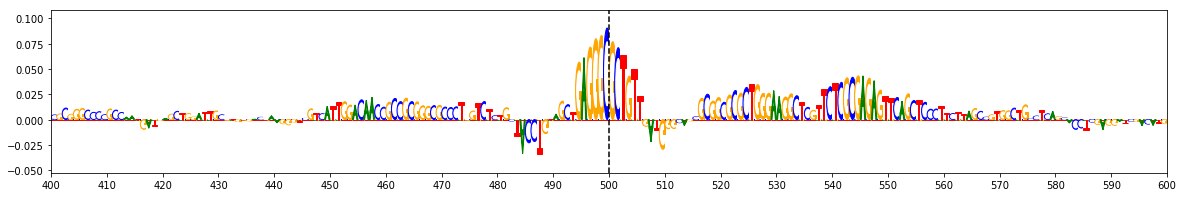

Effect Allele : T   ||   Explain Score : 0.3994   ||   Center / 200bp : 0.1928
Effect Sequence : AGCTGAGGGTGCTGTTGATG


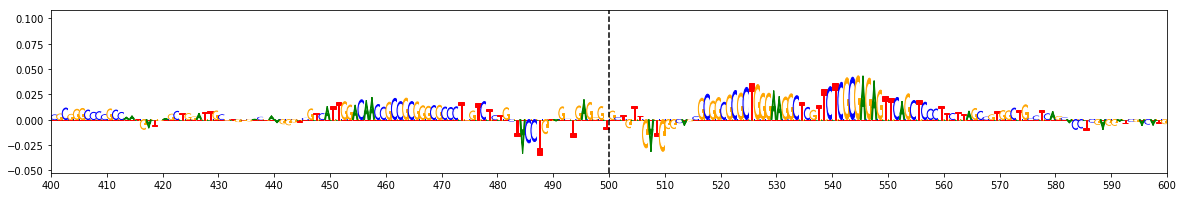

Allele Ratio : 0.3609   ||   Allele Difference : -0.7816  ||  ISM Score : -1.2307  ||  deltaSVM Score : -7.0909


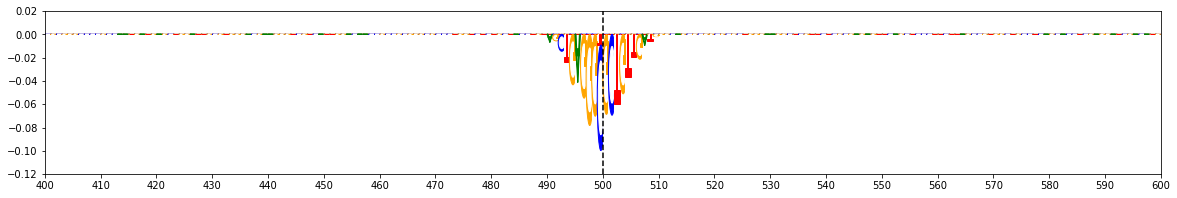


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2303696   ||    chr19 : 18438073 - 18438074   ||    Locus: 236   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  8.40E-01
Alzheimers_Kunkle_2019 		  1.89E-05
Alzheimers_Lambert_2013 	  NAN

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 0.9945   ||   Center / 200bp : 0.3959
Noneffect Sequence : GGCCGTCCCCGCCCCGAACC


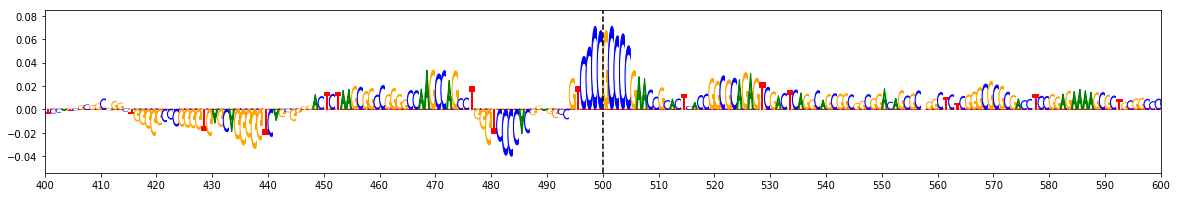

Effect Allele : NAN   ||   Explain Score : 0.4018   ||   Center / 200bp : 0.2086
Effect Sequence : GGCCGTCCCTGCCCCGAACC


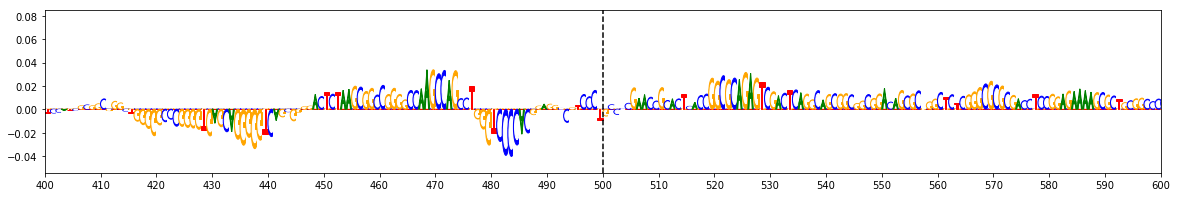

Allele Ratio : 0.404   ||   Allele Difference : -0.5995  ||  ISM Score : -0.9631  ||  deltaSVM Score : -5.435


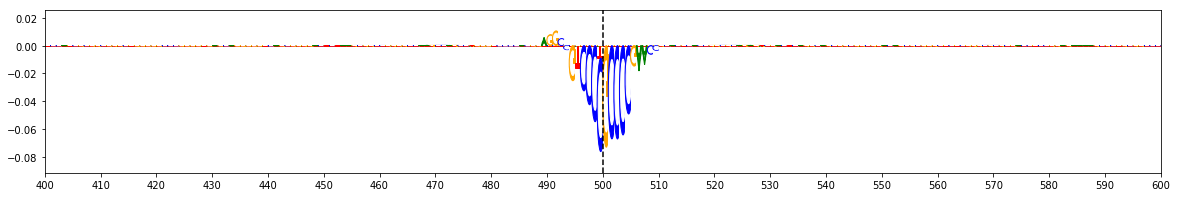


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs872580   ||    chr2 : 95057163 - 95057164   ||    Locus: 316   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  4.04E-02

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.8664   ||   Center / 200bp : 0.4398
Noneffect Sequence : TTCCATGGCACTCGAGCAGC


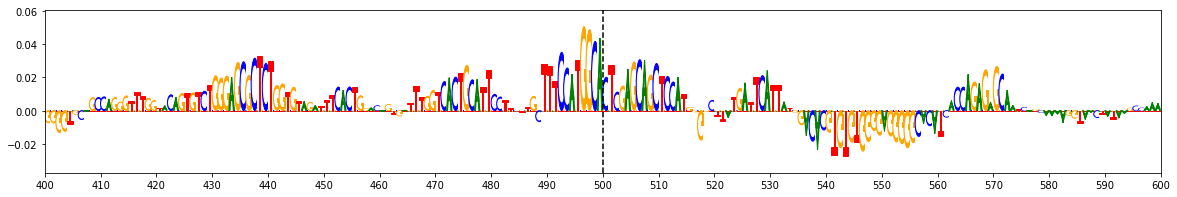

Effect Allele : C   ||   Explain Score : 0.4003   ||   Center / 200bp : 0.2662
Effect Sequence : TTCCATGGCCCTCGAGCAGC


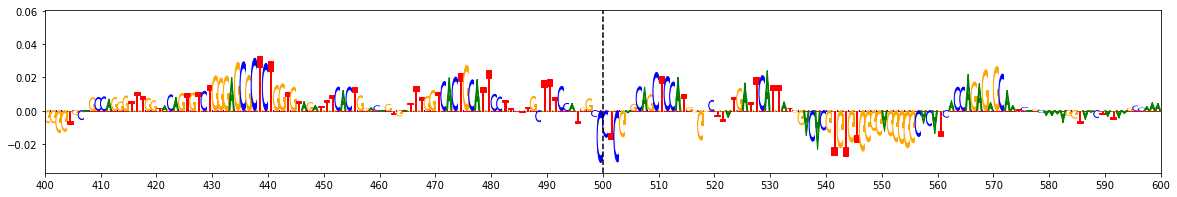

Allele Ratio : 0.462   ||   Allele Difference : -0.5892  ||  ISM Score : -0.9141  ||  deltaSVM Score : -5.3202


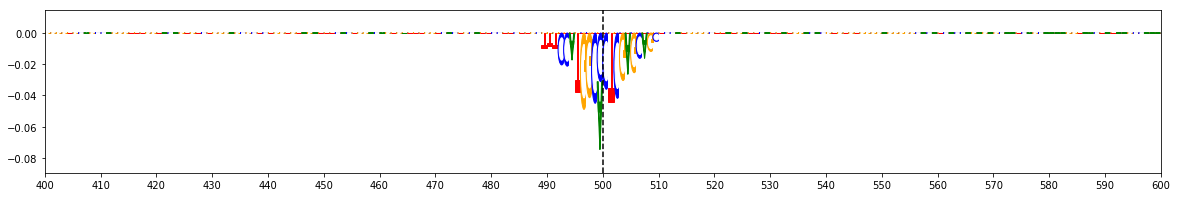


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619361   ||    chr4 : 89836583 - 89836584   ||    Locus: 405   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  2.97E-07
23andme_PD_hg38 		  1.36E-08

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.7356   ||   Center / 200bp : 0.4156
Noneffect Sequence : GTCTCTTTCATTAGGCTCCC


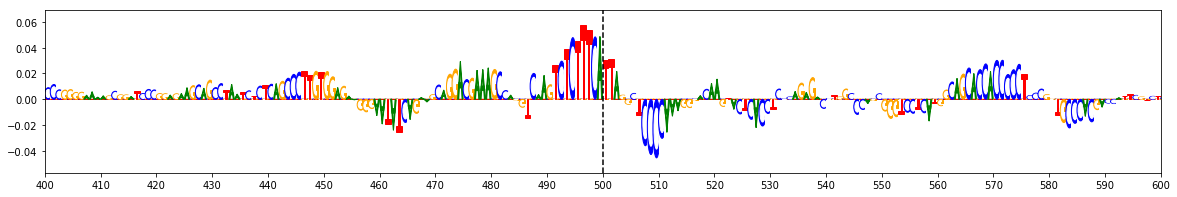

Effect Allele : C   ||   Explain Score : 0.3229   ||   Center / 200bp : 0.2377
Effect Sequence : GTCTCTTTCCTTAGGCTCCC


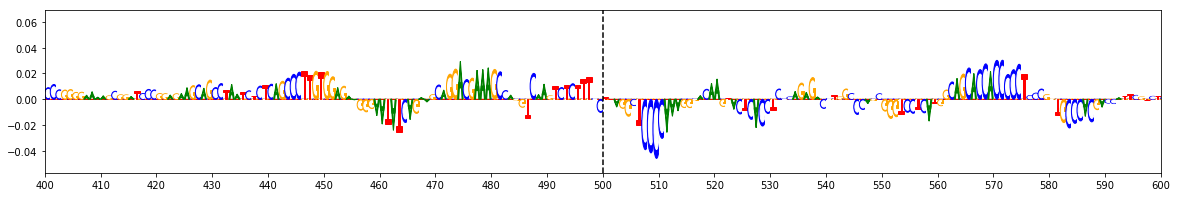

Allele Ratio : 0.439   ||   Allele Difference : -0.4597  ||  ISM Score : -0.7195  ||  deltaSVM Score : -4.1658


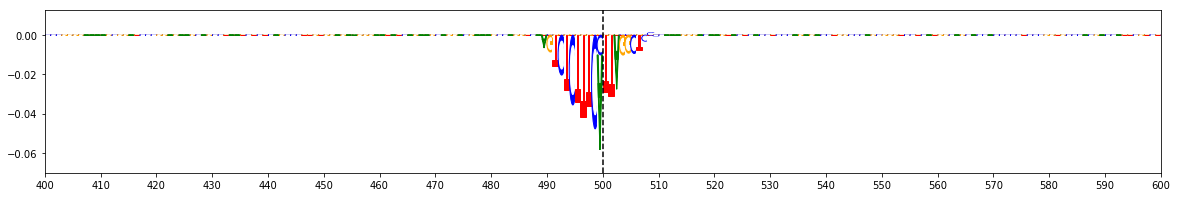


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2250583   ||    chr15 : 58758182 - 58758183   ||    Locus: 58   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  8.26E-09

Coloc:  False

Noneffect Allele : T   ||   Explain Score : 0.979   ||   Center / 200bp : 0.7724
Noneffect Sequence : ATGAGCCATTGAGCCTGGCC


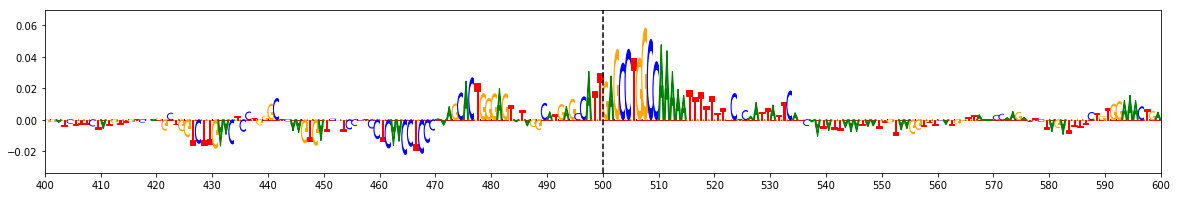

Effect Allele : C   ||   Explain Score : 0.804   ||   Center / 200bp : 0.7358
Effect Sequence : ATGAGCCATCGAGCCTGGCC


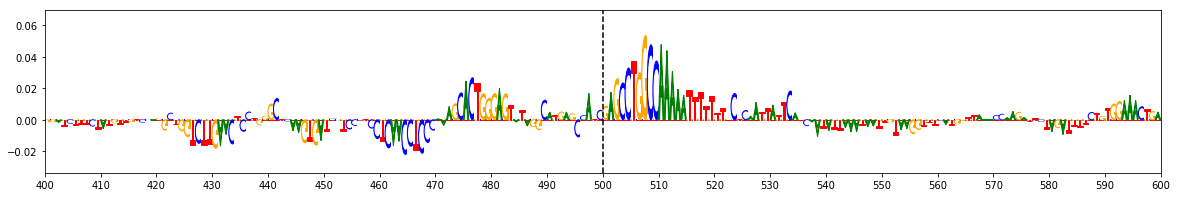

Allele Ratio : 0.8213   ||   Allele Difference : -0.1858  ||  ISM Score : -0.2998  ||  deltaSVM Score : -1.7721


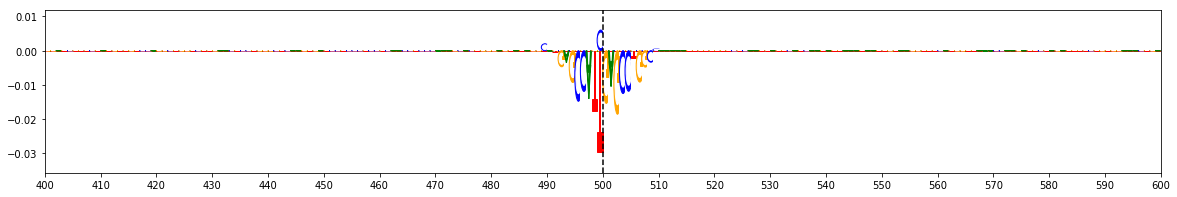


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 242   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.3254   ||   Center / 200bp : 0.6269
Noneffect Sequence : CAACACGGGGCGGGCACAAG


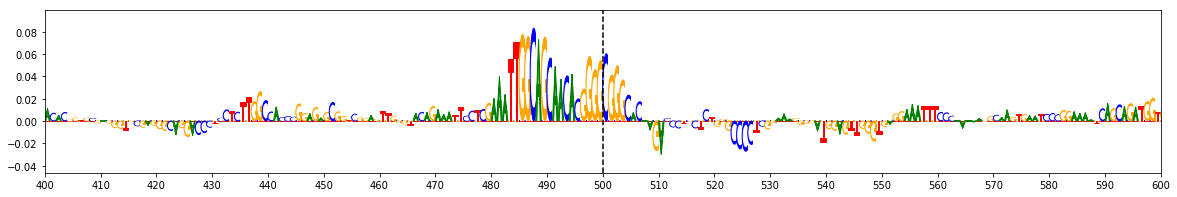

Effect Allele : T   ||   Explain Score : 0.8877   ||   Center / 200bp : 0.529
Effect Sequence : CAACACGGGTCGGGCACAAG


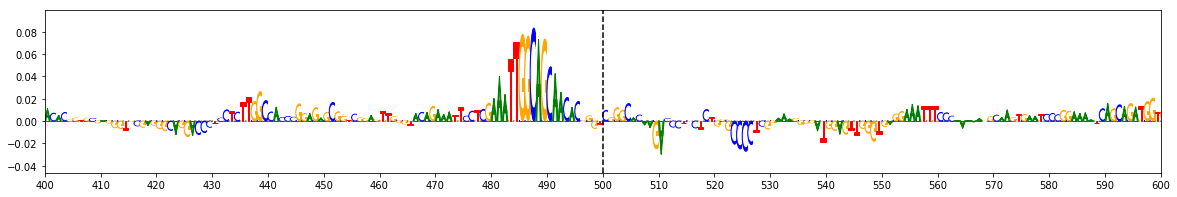

Allele Ratio : 0.6698   ||   Allele Difference : -0.4478  ||  ISM Score : -0.7166  ||  deltaSVM Score : -4.1027


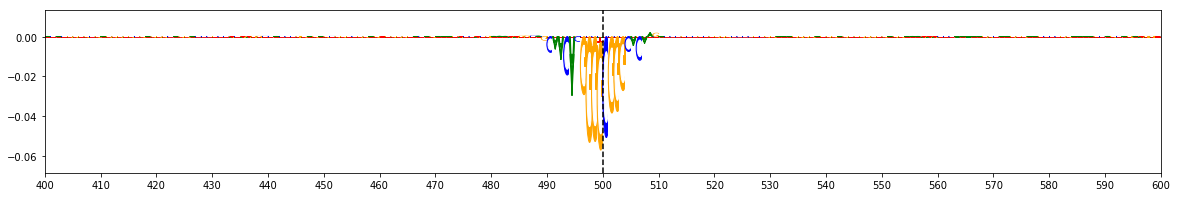


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 315   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.4286   ||   Center / 200bp : 0.4386
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


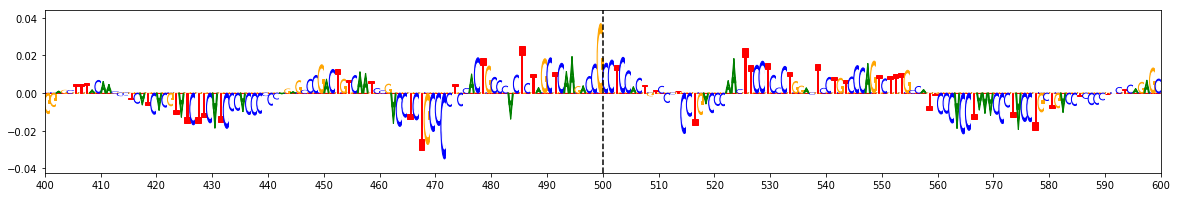

Effect Allele : C   ||   Explain Score : 0.2016   ||   Center / 200bp : 0.2709
Effect Sequence : CTCAAGACCCCCTCCACTGT


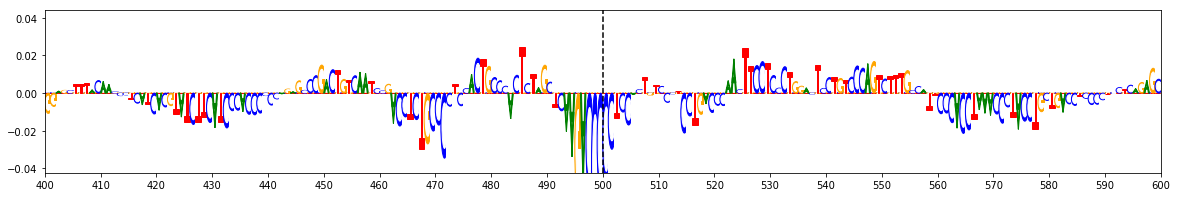

Allele Ratio : 0.4702   ||   Allele Difference : -0.705  ||  ISM Score : -1.1212  ||  deltaSVM Score : -6.4571


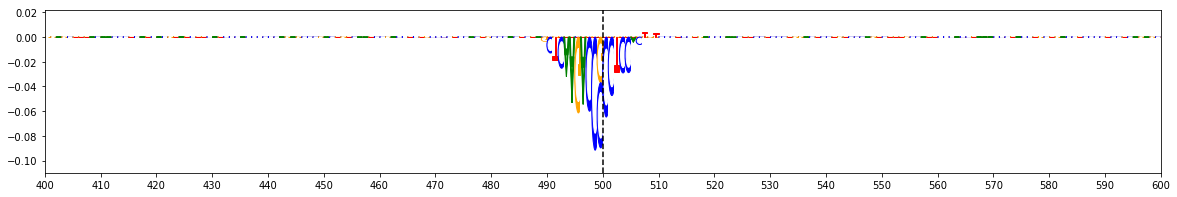


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 416   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.08E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.1243   ||   Center / 200bp : 0.5734
Noneffect Sequence : GGGTTGAGGCGGCTGCTGGG


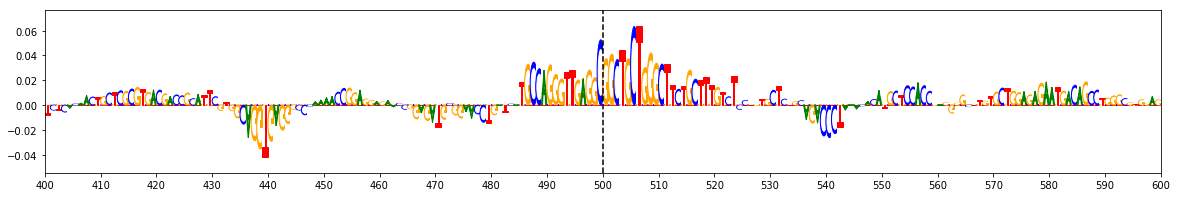

Effect Allele : T   ||   Explain Score : 0.6946   ||   Center / 200bp : 0.4539
Effect Sequence : GGGTTGAGGTGGCTGCTGGG


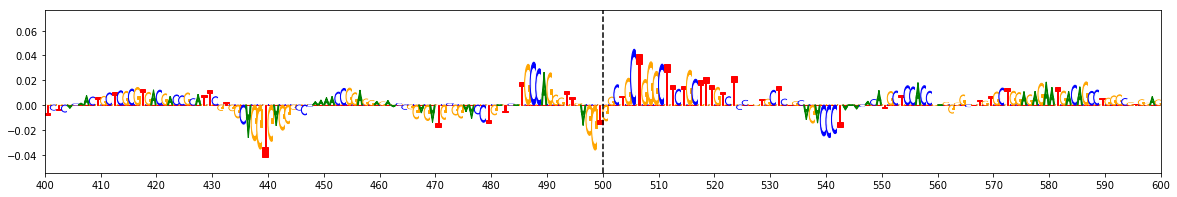

Allele Ratio : 0.6178   ||   Allele Difference : -0.5345  ||  ISM Score : -0.834  ||  deltaSVM Score : -4.8142


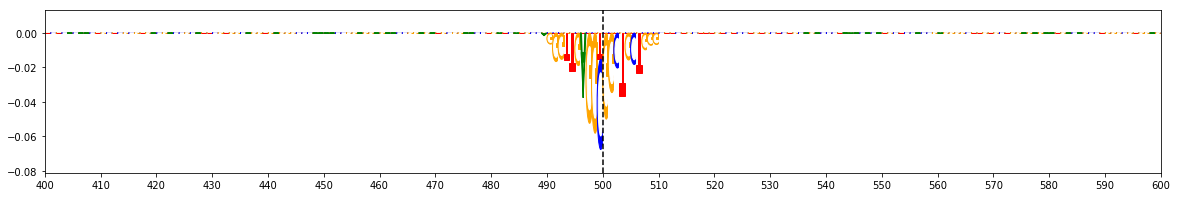


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 121   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 3.8695   ||   Center / 200bp : 0.8761
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


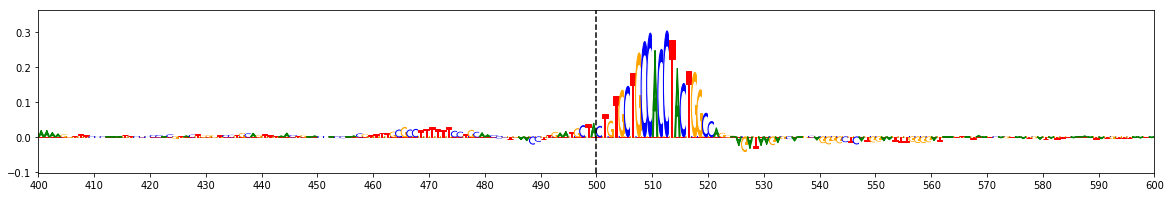

Effect Allele : C   ||   Explain Score : 3.657   ||   Center / 200bp : 0.8698
Effect Sequence : TTGAATGCTCCTGTGCTGCC


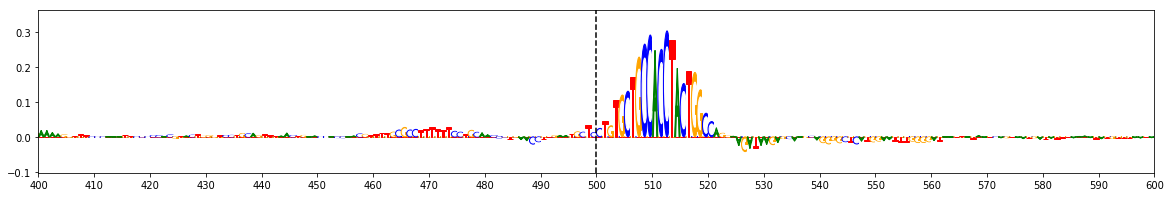

Allele Ratio : 0.9451   ||   Allele Difference : -0.2133  ||  ISM Score : -0.3343  ||  deltaSVM Score : -1.9596


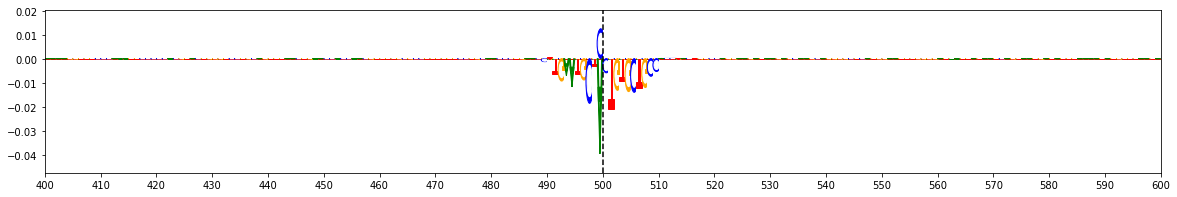


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs117310449   ||    chr19 : 44890258 - 44890259   ||    Locus: 265   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.04E-94
Alzheimers_Kunkle_2019 		  2.28E-46
Alzheimers_Lambert_2013 	  3.69E-36

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.6668   ||   Center / 200bp : 0.5824
Noneffect Sequence : GGCCAGAGGCAGAGTGATGA


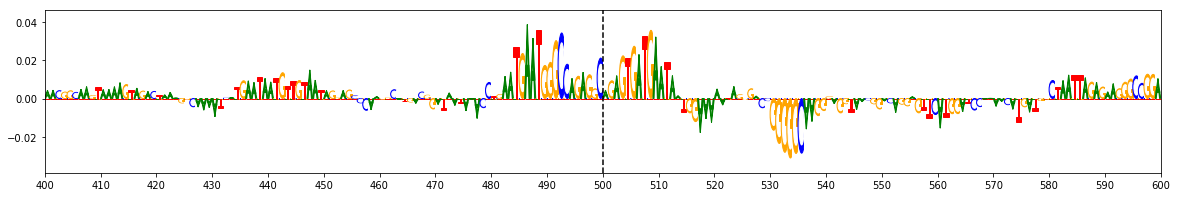

Effect Allele : T   ||   Explain Score : 0.4339   ||   Center / 200bp : 0.4755
Effect Sequence : GGCCAGAGGTAGAGTGATGA


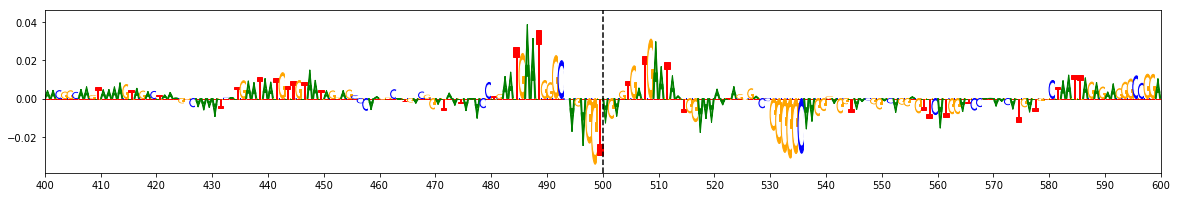

Allele Ratio : 0.6508   ||   Allele Difference : -0.3988  ||  ISM Score : -0.6338  ||  deltaSVM Score : -3.6717


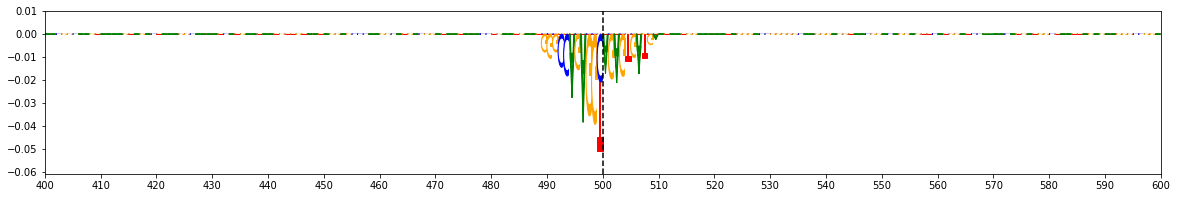


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 406   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.3158   ||   Center / 200bp : 0.6043
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


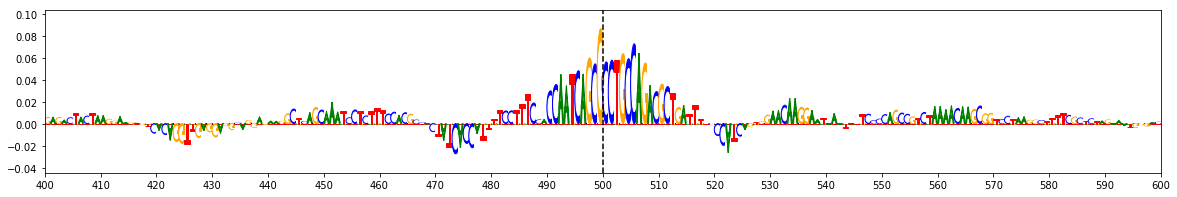

Effect Allele : NAN   ||   Explain Score : 0.8895   ||   Center / 200bp : 0.506
Effect Sequence : CCAATCAGCCCCTGCCAGAC


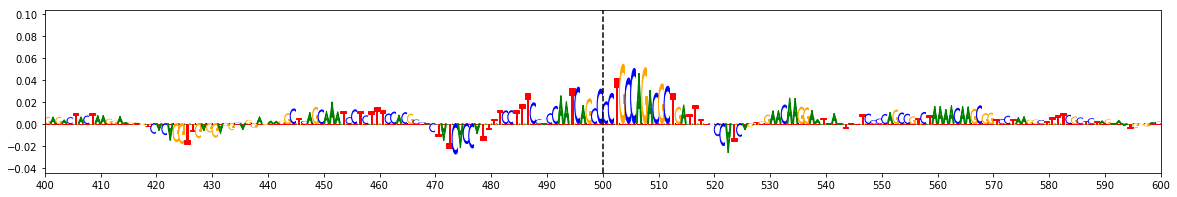

Allele Ratio : 0.676   ||   Allele Difference : -0.4286  ||  ISM Score : -0.6391  ||  deltaSVM Score : -3.9625


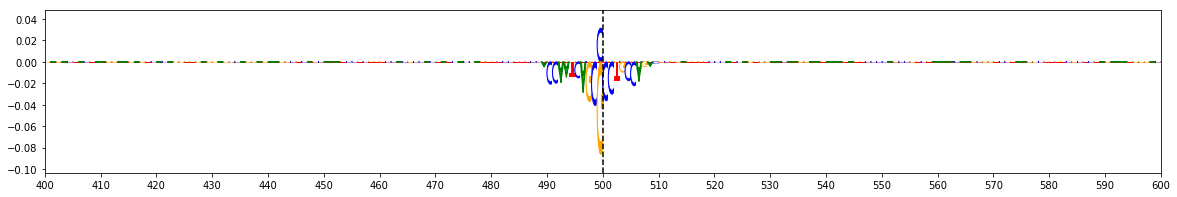


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062785   ||    chr17 : 45947195 - 45947196   ||    Locus: 151   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.33E-22

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.295   ||   Center / 200bp : 0.5244
Noneffect Sequence : CTCCCAGTGGCTGCCTGTGT


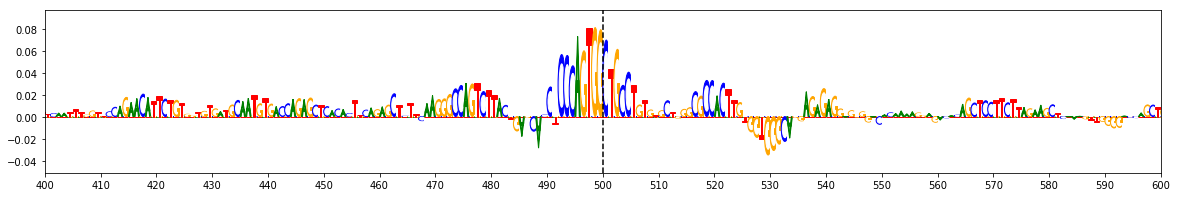

Effect Allele : T   ||   Explain Score : 0.765   ||   Center / 200bp : 0.3945
Effect Sequence : CTCCCAGTGTCTGCCTGTGT


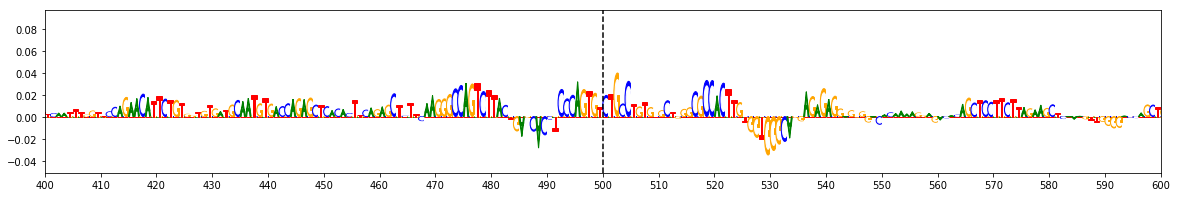

Allele Ratio : 0.5907   ||   Allele Difference : -0.5559  ||  ISM Score : -0.8702  ||  deltaSVM Score : -5.076


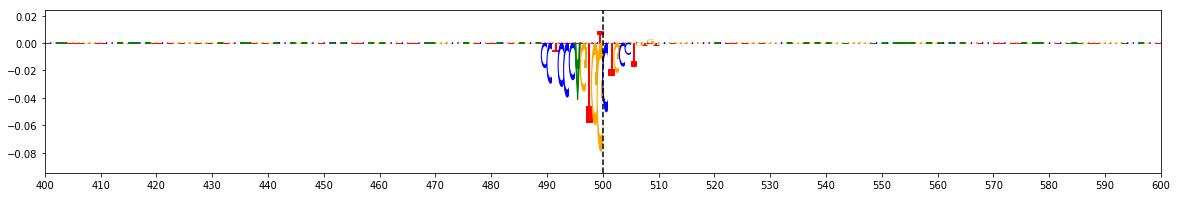


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2965169   ||    chr19 : 44747898 - 44747899   ||    Locus: 250   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.13E-57
Alzheimers_Kunkle_2019 		  2.75E-37
Alzheimers_Lambert_2013 	  5.18E-36

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.553   ||   Center / 200bp : 0.7257
Noneffect Sequence : CCCCCAACGAGTGCAGAGAC


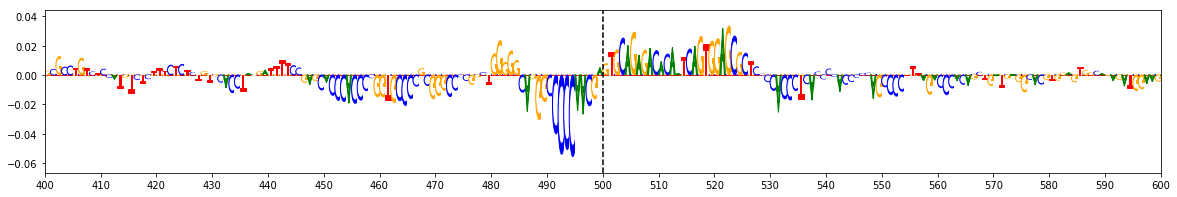

Effect Allele : C   ||   Explain Score : 0.4569   ||   Center / 200bp : 0.686
Effect Sequence : CCCCCAACGCGTGCAGAGAC


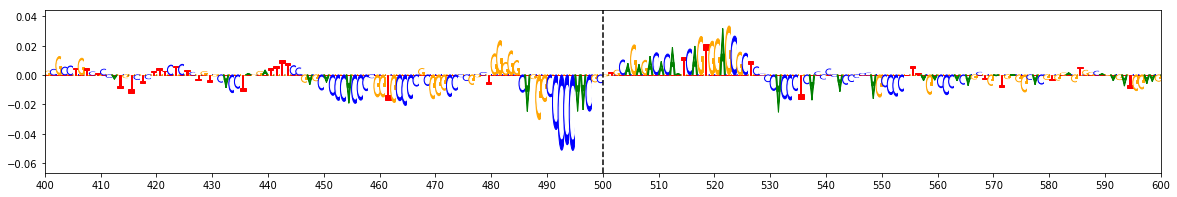

Allele Ratio : 0.8261   ||   Allele Difference : -0.0794  ||  ISM Score : -0.1271  ||  deltaSVM Score : -0.7219


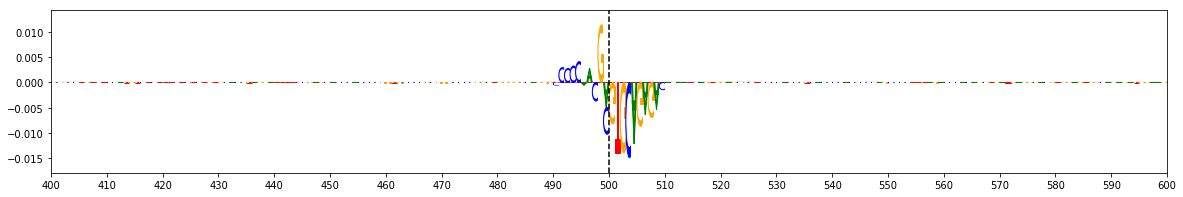


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4802235   ||    chr19 : 44721571 - 44721572   ||    Locus: 247   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  1.05E-13
Alzheimers_Lambert_2013 	  6.86E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.6426   ||   Center / 200bp : 0.6362
Noneffect Sequence : TGCAGTGGCGCAATCTCGGC


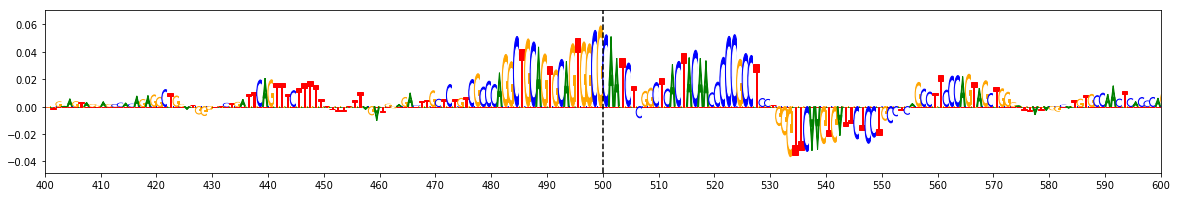

Effect Allele : T   ||   Explain Score : 1.2029   ||   Center / 200bp : 0.5613
Effect Sequence : TGCAGTGGCTCAATCTCGGC


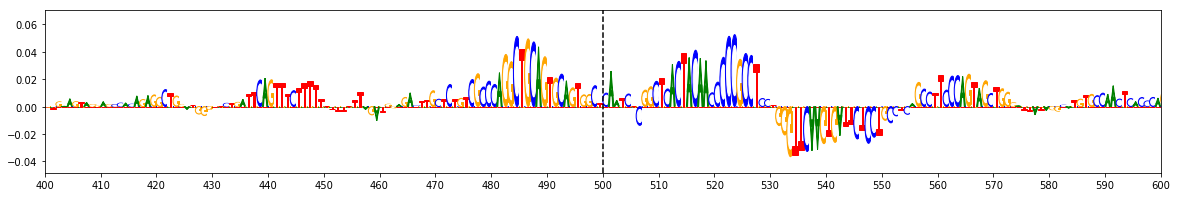

Allele Ratio : 0.7323   ||   Allele Difference : -0.4453  ||  ISM Score : -0.7523  ||  deltaSVM Score : -4.3338


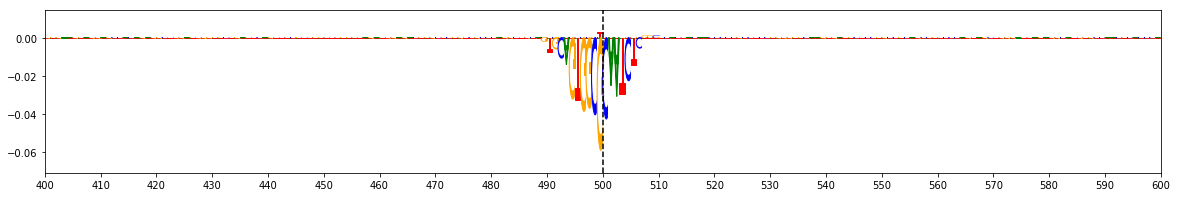


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7214776   ||    chr17 : 4908319 - 4908320   ||    Locus: 98   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  9.21E-04
Alzheimers_Lambert_2013 	  4.27E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.6594   ||   Center / 200bp : 0.4384
Noneffect Sequence : GCATTCACCCGAGAGCCAGG


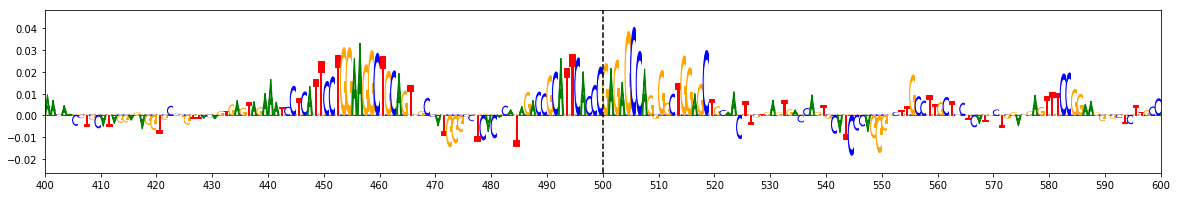

Effect Allele : T   ||   Explain Score : 0.3455   ||   Center / 200bp : 0.2903
Effect Sequence : GCATTCACCTGAGAGCCAGG


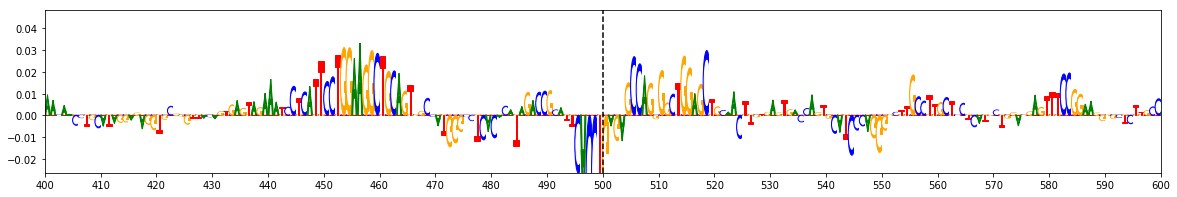

Allele Ratio : 0.524   ||   Allele Difference : -0.6464  ||  ISM Score : -1.018  ||  deltaSVM Score : -5.8481


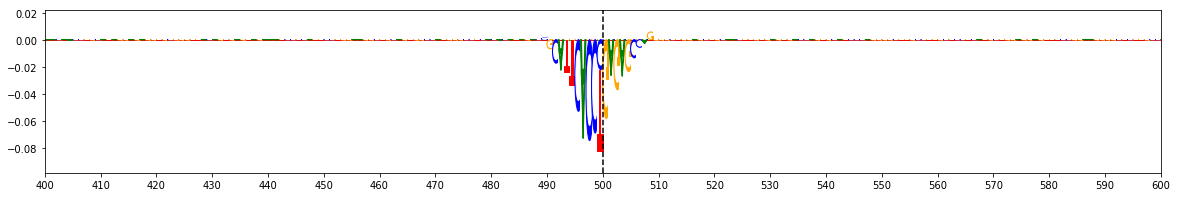


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8103622   ||    chr19 : 18462023 - 18462024   ||    Locus: 238   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  7.31E-02
Alzheimers_Kunkle_2019 		  1.28E-05
Alzheimers_Lambert_2013 	  3.29E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 2.34   ||   Center / 200bp : 0.6691
Noneffect Sequence : GACCAAGAGCGCCACCTGCT


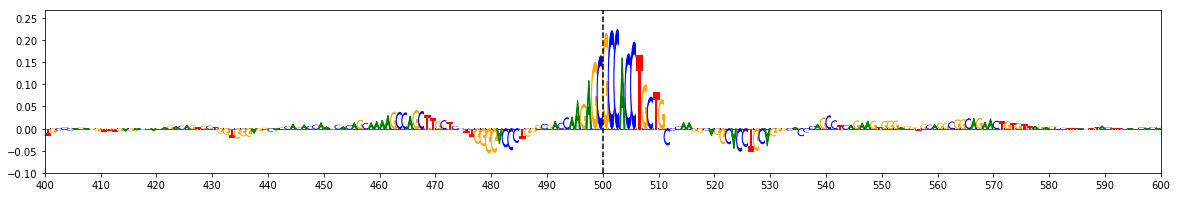

Effect Allele : T   ||   Explain Score : 1.9361   ||   Center / 200bp : 0.6261
Effect Sequence : GACCAAGAGTGCCACCTGCT


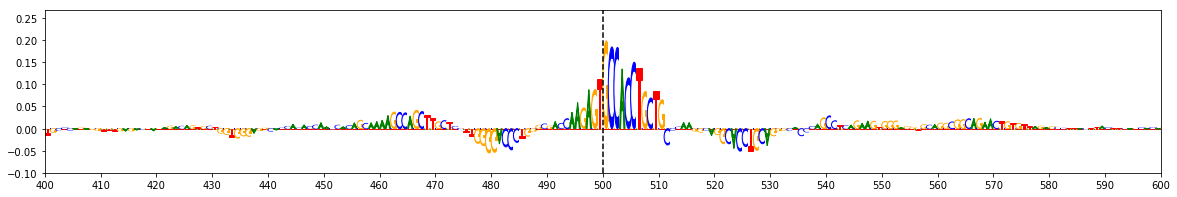

Allele Ratio : 0.8274   ||   Allele Difference : -0.4034  ||  ISM Score : -0.6624  ||  deltaSVM Score : -3.7708


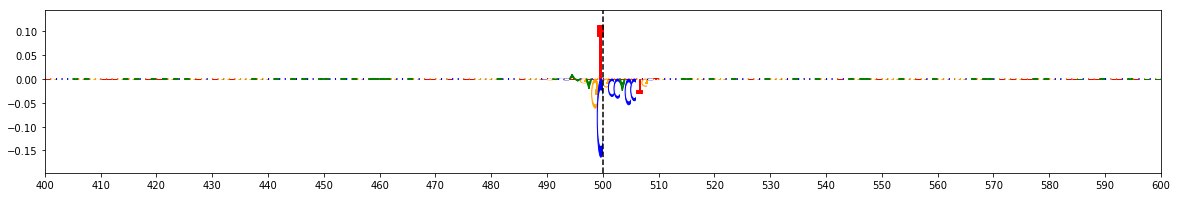


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62061809   ||    chr17 : 46101472 - 46101473   ||    Locus: 190   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.62E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.702   ||   Center / 200bp : 0.7472
Noneffect Sequence : TTAGTCAGCCGGGCACGGTG


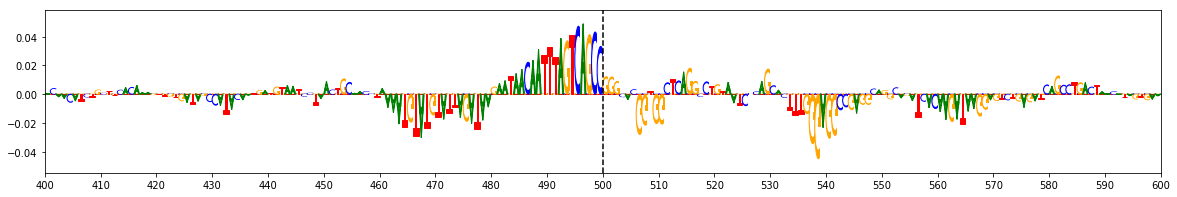

Effect Allele : T   ||   Explain Score : 0.6499   ||   Center / 200bp : 0.7321
Effect Sequence : TTAGTCAGCTGGGCACGGTG


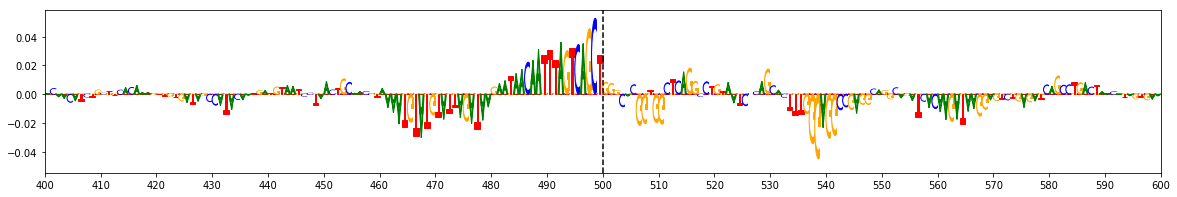

Allele Ratio : 0.9257   ||   Allele Difference : -0.0487  ||  ISM Score : -0.0779  ||  deltaSVM Score : -0.4437


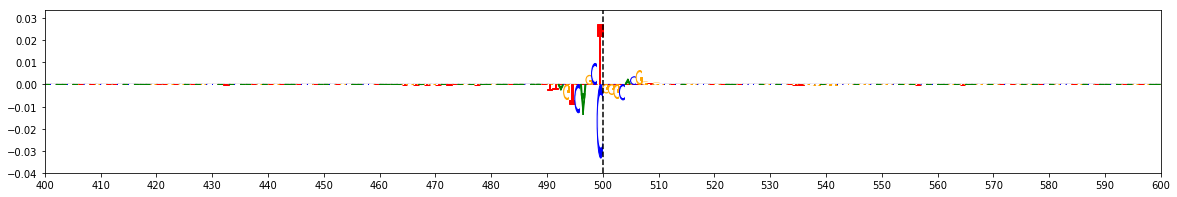


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7569049   ||    chr2 : 101736882 - 101736883   ||    Locus: 324   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.65E-03
Chang_23andMe_Parkinsons 	  1.65E-03

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 1.4186   ||   Center / 200bp : 0.6385
Noneffect Sequence : TAAAGCAGTGAAAGCCCTGG


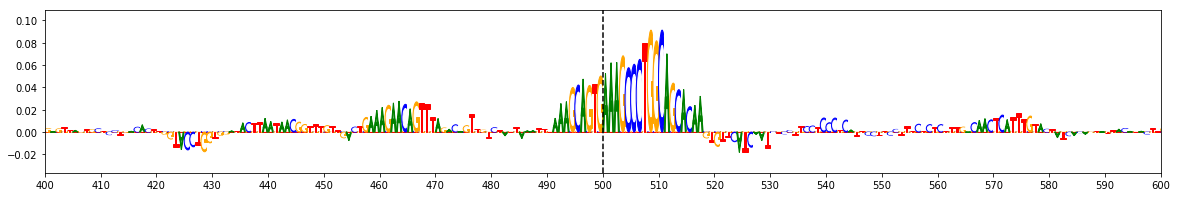

Effect Allele : T   ||   Explain Score : 1.128   ||   Center / 200bp : 0.5841
Effect Sequence : TAAAGCAGTTAAAGCCCTGG


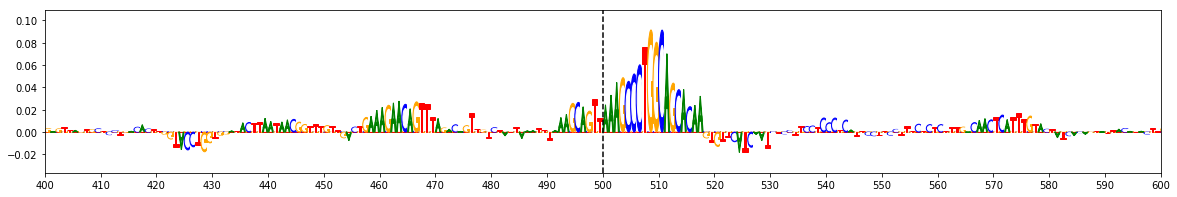

Allele Ratio : 0.7951   ||   Allele Difference : -0.2978  ||  ISM Score : -0.4659  ||  deltaSVM Score : -2.6943


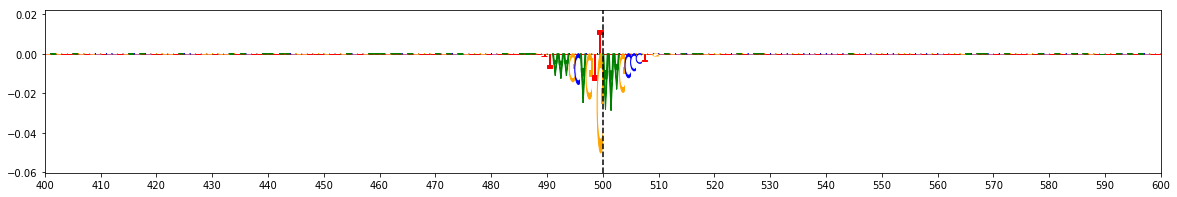


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79436576   ||    chr17 : 4901871 - 4901872   ||    Locus: 94   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  3.06E-04
Alzheimers_Lambert_2013 	  4.79E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.6843   ||   Center / 200bp : 0.4372
Noneffect Sequence : CGGTTGGCCCCGCCCCATAA


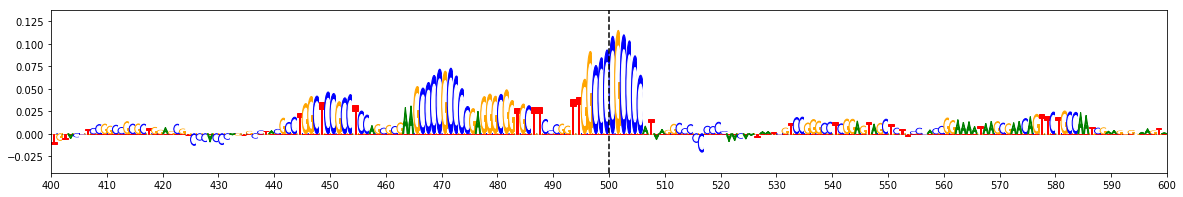

Effect Allele : T   ||   Explain Score : 0.9651   ||   Center / 200bp : 0.3053
Effect Sequence : CGGTTGGCCTCGCCCCATAA


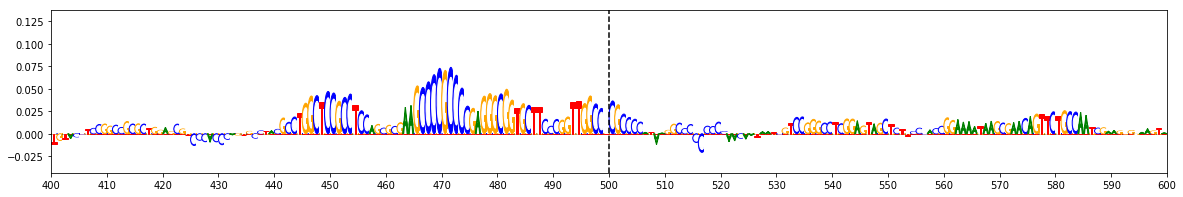

Allele Ratio : 0.573   ||   Allele Difference : -0.726  ||  ISM Score : -1.1338  ||  deltaSVM Score : -6.6856


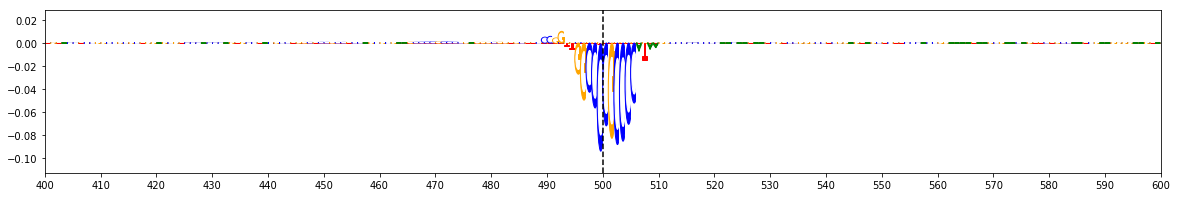


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7225684   ||    chr17 : 4838422 - 4838423   ||    Locus: 80   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  9.14E-04
Alzheimers_Lambert_2013 	  1.08E-01

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.2083   ||   Center / 200bp : 0.6142
Noneffect Sequence : CACCCCCTCGCTCTTGCCCC


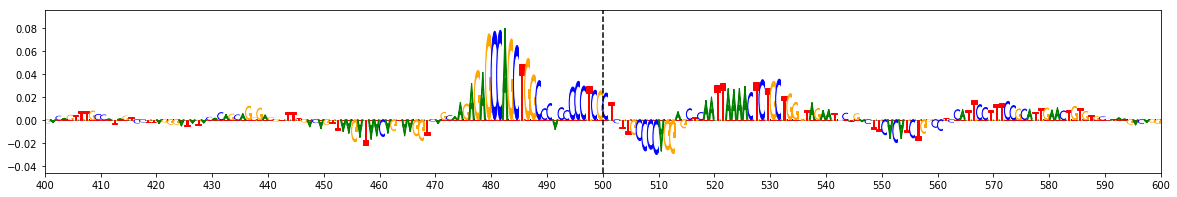

Effect Allele : A   ||   Explain Score : 0.9776   ||   Center / 200bp : 0.563
Effect Sequence : CACCCCCTCACTCTTGCCCC


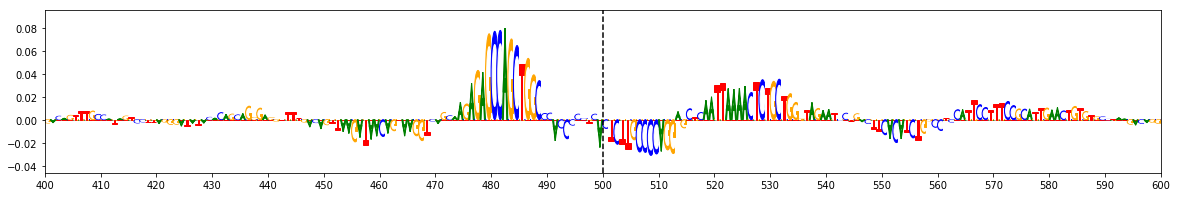

Allele Ratio : 0.809   ||   Allele Difference : -0.388  ||  ISM Score : -0.5978  ||  deltaSVM Score : -3.5167


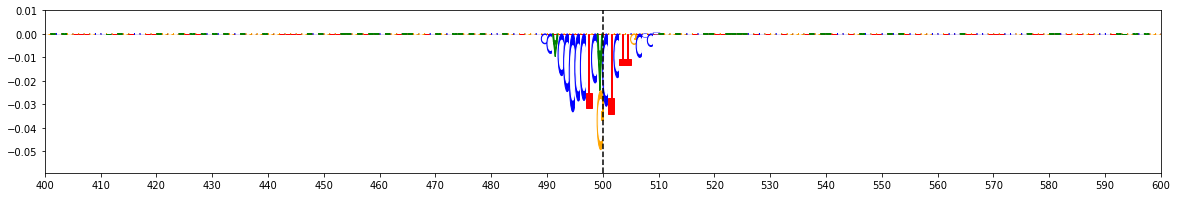


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref    alt  \
181  chr17   45992744   45992745   rs62063842      G         C   G      C   
27   chr11   65834088   65834089   rs17854357      C         G   G    C,T   
439   chr8   11845330   11845331    rs1736081      T         G   T      G   
201  chr17   46213482   46213483   rs76475191      T         A   T      A   
390   chr4   15735477   15735478   rs11724635      C         A   C      A   
389   chr4     987143     987144   rs10902762      G         A   G      A   
34   chr11   86092233   86092234     rs572979      T         C   C      T   
285  chr19   44950978   44950979    rs7246900      A         G   G      A   
193  chr17   46118128   46118129     rs727425      G         A   G      A   
277  chr19   44912841   44912842   rs72654437      A         G   G      A   
202  chr17   46213483   46213484   rs78826239      T         A   T      A   
185  chr17   46003857   46003858   rs17573509      G         A   G      A   
46   chr12  122842050  122842051   rs10847864      T         G   G  A,C,T   
74   chr16   31106091   31106092    rs2032915      T         C   C      T   
62   chr15   64453059   64453060  rs143560707      G         C   C      G   
109  chr17   45815421   45815422   rs55668363      G         A   G      A   
148  chr17   45942947   45942948   rs62062772      T         C   C      T   
166  chr17   45955821   45955822  rs112950348      G         A   G    A,C   
408   chr4  113453656  113453657   rs17046072      T         C   C    G,T   
366   chr3   52300359   52300360  rs142135910      C         A   A      C   
206  chr17   46771150   46771151     rs199523      C         A   C      A   
445   chr8   22599691   22599692     rs755934      T         G   T      G   
334   chr2  127084806  127084807   rs11691237      T         C   C      T   
170  chr17   45975366   45975367   rs78104015      G         A   A      G   
3     chr1  171699810  171699811   rs10913511      G         A   G      A   
248  chr19   44723890   44723891  rs150820726      T         A   A      T   
327   chr2  101762281  101762282    rs2068397      C         A   C      A   
187  chr17   46004160   46004161   rs62064665      T         C   T      C   
152  chr17   45947293   45947294   rs62062786      G         C   G    A,C   
200  chr17   46213392   46213393    rs2668662      T         C   T      C   
..     ...        ...        ...          ...    ...       ...  ..    ...   
161  chr17   45955548   45955549   rs17571739      T         C   T      C   
457   chr9   17579691   17579692   rs13294100      T         G   T      G   
305  chr19   45045876   45045877  rs112481437      A         G   G      A   
182  chr17   46002200   46002201   rs17573447      T         C   C      T   
387   chr4     986675     986676    rs4690220      G         A   A      G   
386   chr4     973656     973657   rs13137144      G         A   G    A,C   
304  chr19   45039212   45039213   rs34034621      T         C   C      T   
197  chr17   46192597   46192598   rs11079733      T         A   T      A   
154  chr17   45949123   45949124   rs77266933      C         A   A      C   
82   chr17    4858044    4858045   rs72835024      T         G   G      T   
284  chr19   44915228   44915229   rs12691088      A         G   G    A,C   
167  chr17   45973456   45973457   rs62063775      T         G   G    A,T   
413   chr5  103010211  103010212    rs1826673      G         A   G      A   
207  chr17   49373412   49373413   rs28394864      A         G   G    A,C   
398   chr4   89765967   89765968    rs3775427      G         A   G      A   
23   chr11   47426945   47426946   rs11600581      T         C   T    A,C   
96   chr17    4902141    4902142   rs72835061      A         C   C      A   
126  chr17   45894237   45894238   rs62056778      G         C   C      G   
432   chr7   23222815   23222816    rs1624451      T         A   T      A   
93   chr17    4881683    4881684  rs145035851      T         C   C      T   
251

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs62063842   ||    chr17 : 45992744 - 45992745   ||    Locus: 181   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.19E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.2891   ||  Center / 200bp: 0.3834
Effect Sequence: AAATAATTAGCTGGGCGTGG


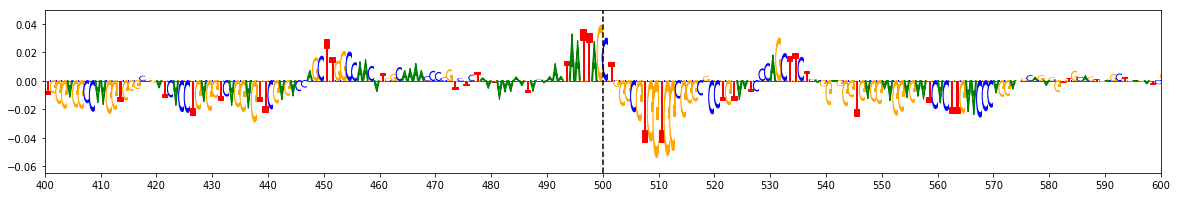

Noneffect Allele: C   ||  Explain Score: 0.0583   ||  Center / 200bp: 0.1112
Noneffect Sequence: AAATAATTACCTGGGCGTGG


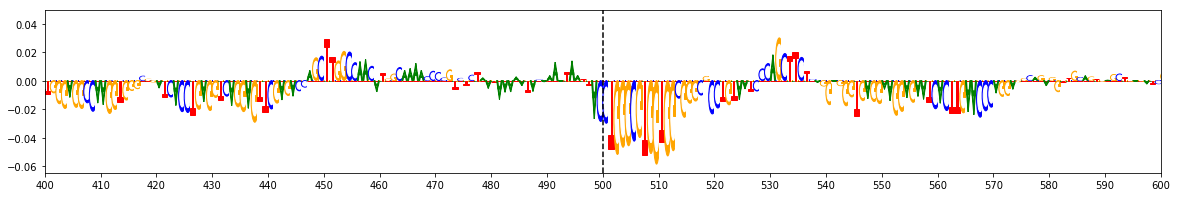

Allele Ratio : 4.9578   ||   Allele Difference : 0.531  ||  ISM Score : 0.8549  ||  deltaSVM Score : 4.8799


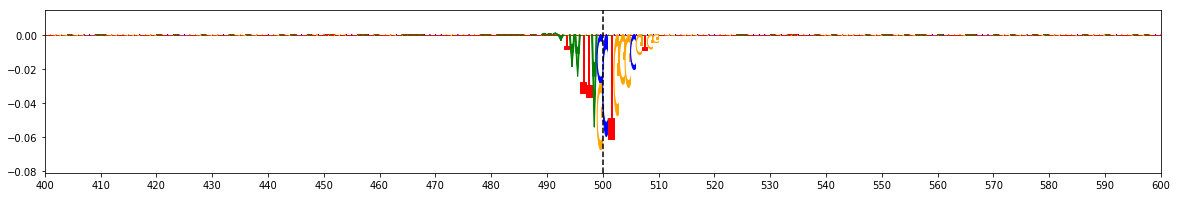


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17854357   ||    chr11 : 65834088 - 65834089   ||    Locus: 27   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.26E-06

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.5614   ||  Center / 200bp: 0.4331
Effect Sequence: GGAGGTTGGCAAGGAGGGCA


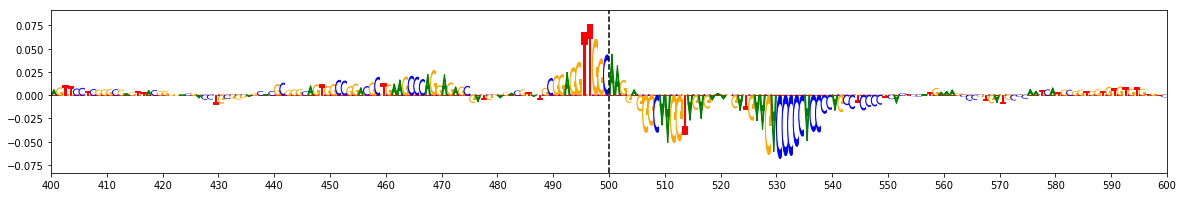

Noneffect Allele: G   ||  Explain Score: 0.2138   ||  Center / 200bp: 0.2254
Noneffect Sequence: GGAGGTTGGGAAGGAGGGCA


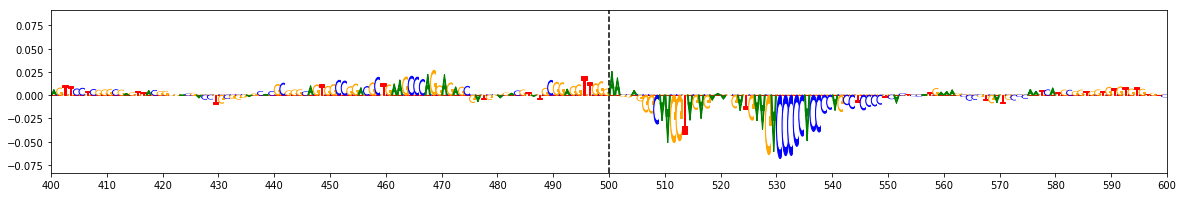

Allele Ratio : 2.6257   ||   Allele Difference : 0.284  ||  ISM Score : 0.4796  ||  deltaSVM Score : 2.7544


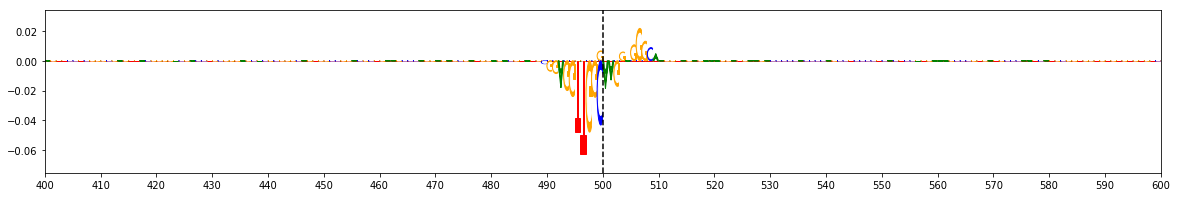


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1736081   ||    chr8 : 11845330 - 11845331   ||    Locus: 439   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.11E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.4853   ||  Center / 200bp: 0.5065
Effect Sequence: TCCTGCTGTTGGCCCACTAG


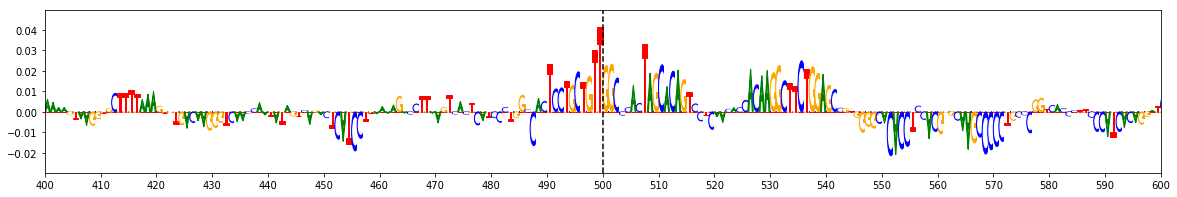

Noneffect Allele: G   ||  Explain Score: 0.2171   ||  Center / 200bp: 0.3158
Noneffect Sequence: TCCTGCTGTGGGCCCACTAG


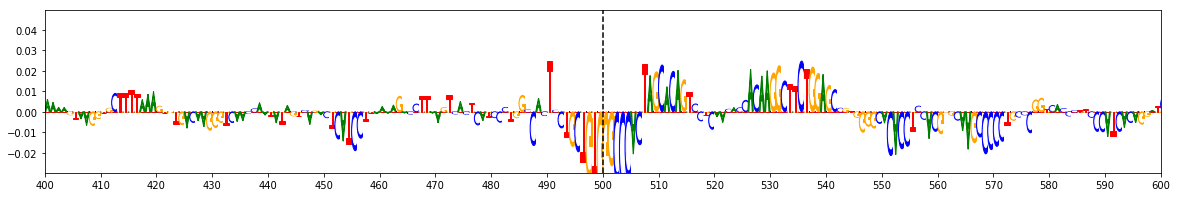

Allele Ratio : 2.2351   ||   Allele Difference : 0.6679  ||  ISM Score : 1.0395  ||  deltaSVM Score : 5.9882


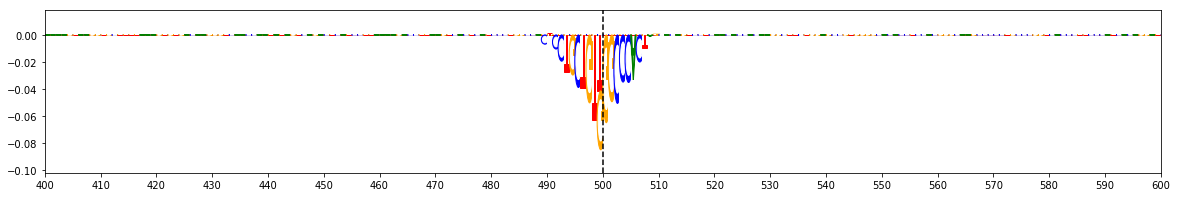


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76475191   ||    chr17 : 46213482 - 46213483   ||    Locus: 201   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.10E-18

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6398   ||  Center / 200bp: 0.7218
Effect Sequence: TTTTTTTTTTTTTTTTAGTA


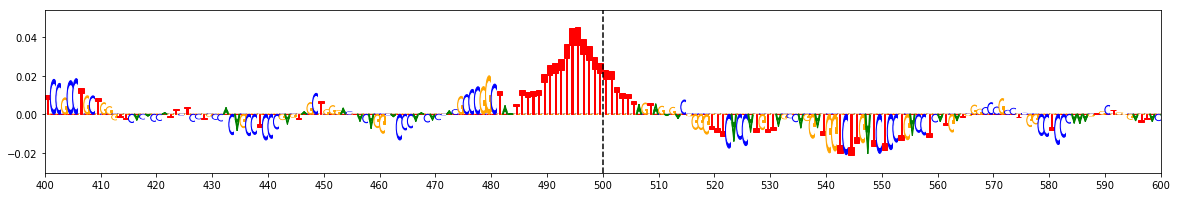

Noneffect Allele: A   ||  Explain Score: 0.4151   ||  Center / 200bp: 0.5591
Noneffect Sequence: TTTTTTTTTATTTTTTAGTA


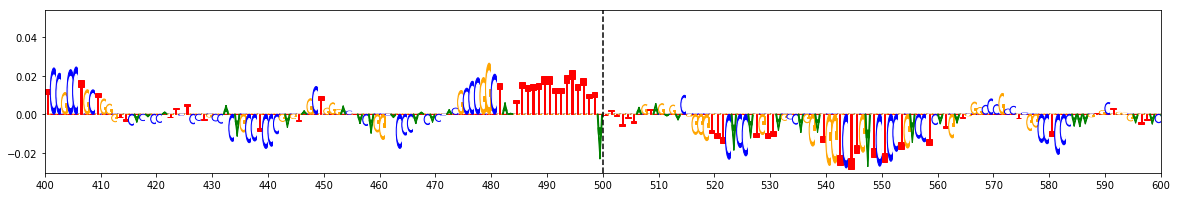

Allele Ratio : 1.541   ||   Allele Difference : 0.2945  ||  ISM Score : 0.3005  ||  deltaSVM Score : 13.019


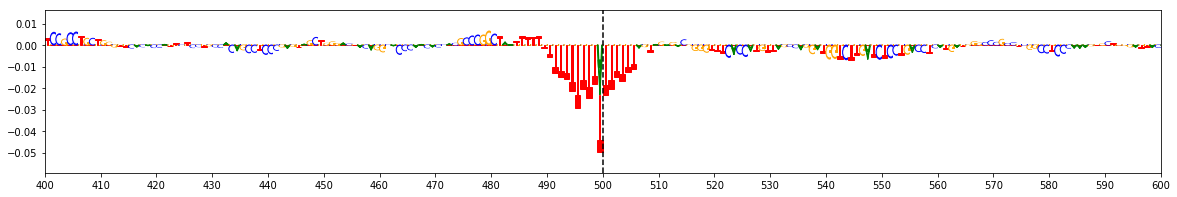


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11724635   ||    chr4 : 15735477 - 15735478   ||    Locus: 390   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.04E-04
Chang_23andMe_Parkinsons 	  1.04E-04

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.6025   ||  Center / 200bp: 0.4512
Effect Sequence: CAAGGGAAGCTTAATAACAA


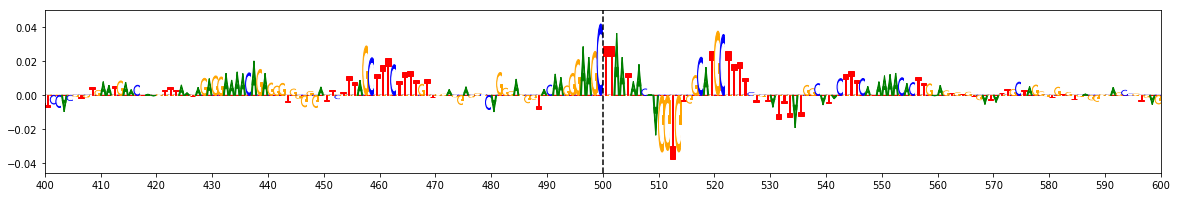

Noneffect Allele: A   ||  Explain Score: 0.2545   ||  Center / 200bp: 0.2578
Noneffect Sequence: CAAGGGAAGATTAATAACAA


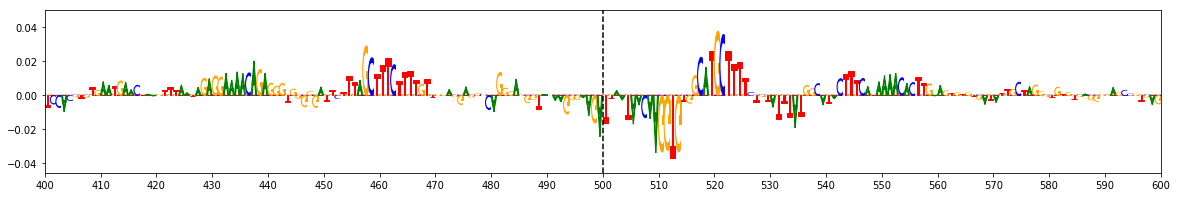

Allele Ratio : 2.3676   ||   Allele Difference : 0.5195  ||  ISM Score : 0.8146  ||  deltaSVM Score : 4.721


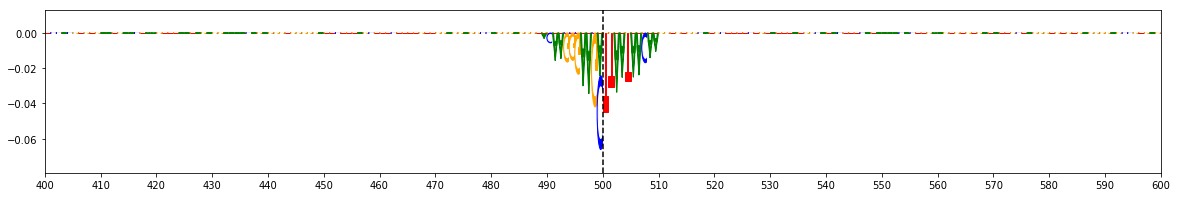


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 389   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.6386   ||  Center / 200bp: 0.5415
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


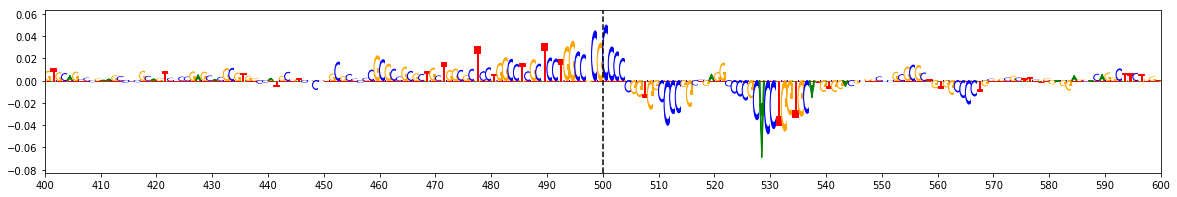

Noneffect Allele: A   ||  Explain Score: 0.3632   ||  Center / 200bp: 0.398
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


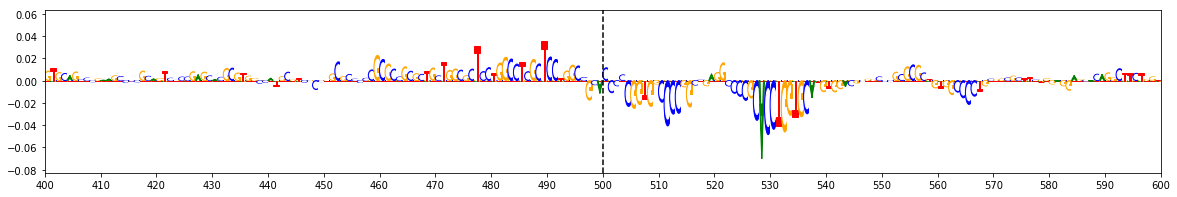

Allele Ratio : 1.7584   ||   Allele Difference : 0.3536  ||  ISM Score : 0.5748  ||  deltaSVM Score : 3.4568


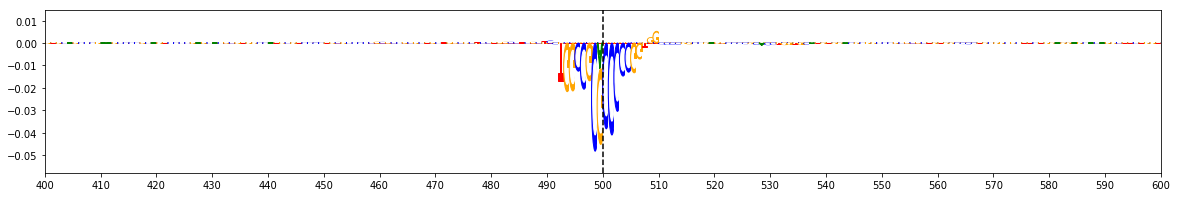


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs572979   ||    chr11 : 86092233 - 86092234   ||    Locus: 34   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.19E-08

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.9462   ||  Center / 200bp: 0.6491
Effect Sequence: GCCTGTAATTGCAGCACTTC


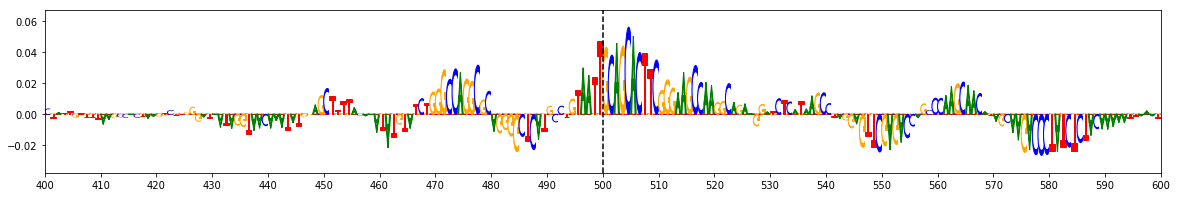

Noneffect Allele: C   ||  Explain Score: 0.6617   ||  Center / 200bp: 0.5641
Noneffect Sequence: GCCTGTAATCGCAGCACTTC


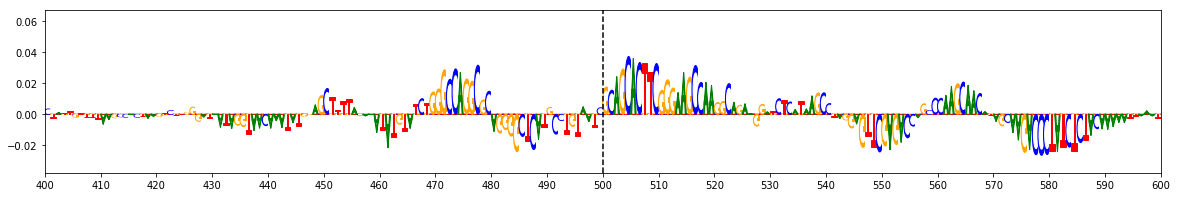

Allele Ratio : 1.43   ||   Allele Difference : 0.3397  ||  ISM Score : 0.5327  ||  deltaSVM Score : 3.0731


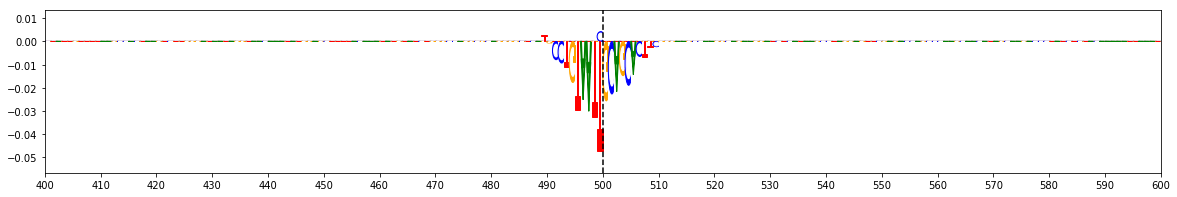


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7246900   ||    chr19 : 44950978 - 44950979   ||    Locus: 285   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.51E-10
Alzheimers_Kunkle_2019 		  1.55E-13
Alzheimers_Lambert_2013 	  5.59E-11

Coloc:  True

Effect Allele: A   ||  Explain Score: 1.2643   ||  Center / 200bp: 0.6447
Effect Sequence: GGAGGCGGAAATAGTGCCAC


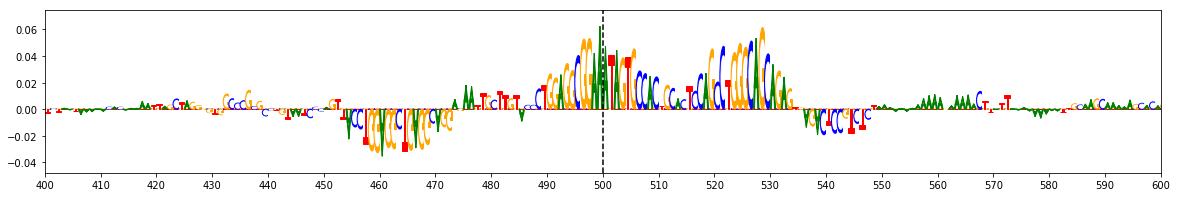

Noneffect Allele: G   ||  Explain Score: 0.9021   ||  Center / 200bp: 0.5648
Noneffect Sequence: GGAGGCGGAGATAGTGCCAC


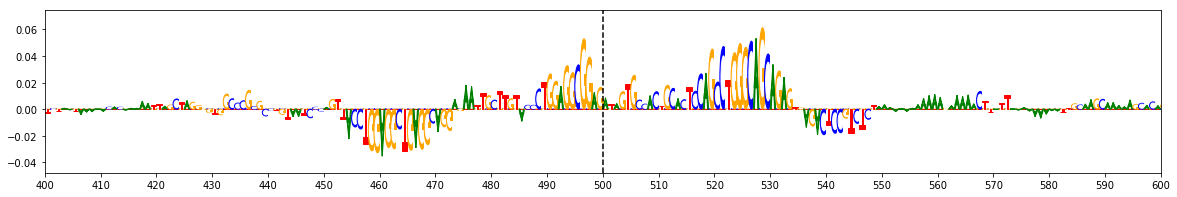

Allele Ratio : 1.4015   ||   Allele Difference : 0.3622  ||  ISM Score : 0.5847  ||  deltaSVM Score : 3.3749


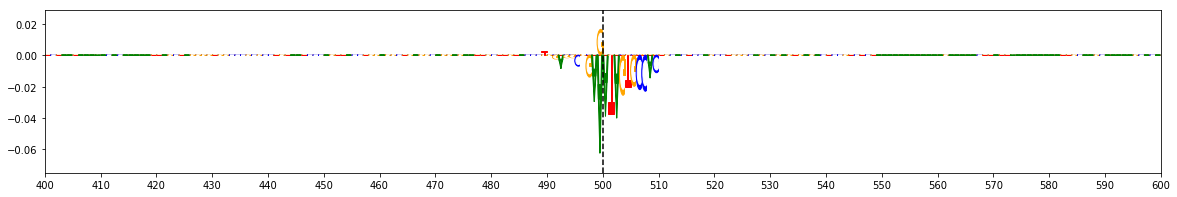


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs727425   ||    chr17 : 46118128 - 46118129   ||    Locus: 193   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.81E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.6034   ||  Center / 200bp: 0.5814
Effect Sequence: ATGAAGCAAGCTTTACACAC


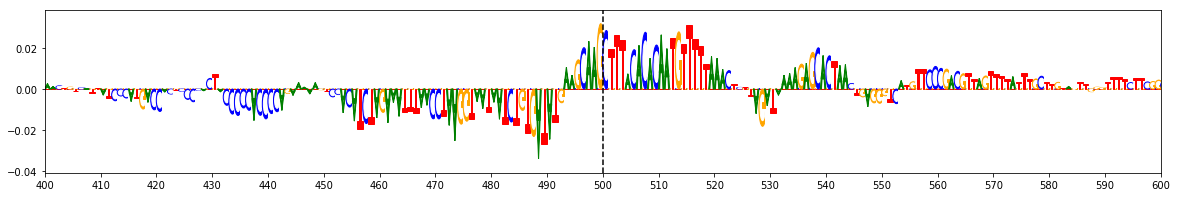

Noneffect Allele: A   ||  Explain Score: 0.3934   ||  Center / 200bp: 0.4752
Noneffect Sequence: ATGAAGCAAACTTTACACAC


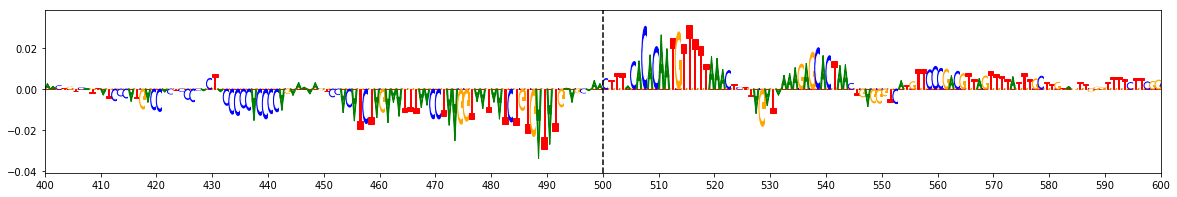

Allele Ratio : 1.5337   ||   Allele Difference : 0.2323  ||  ISM Score : 0.3624  ||  deltaSVM Score : 2.0704


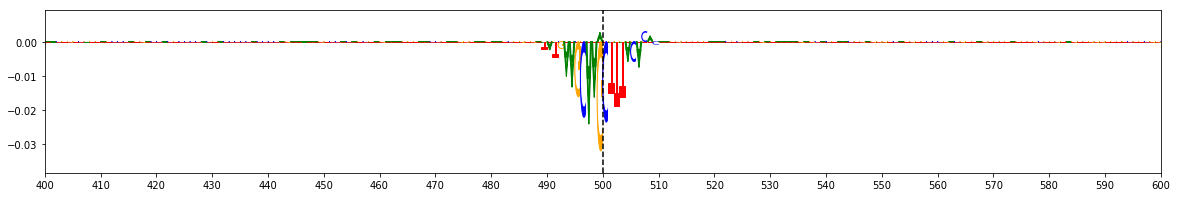


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72654437   ||    chr19 : 44912841 - 44912842   ||    Locus: 277   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.28E-09

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.6993   ||  Center / 200bp: 0.5942
Effect Sequence: ATTCTTGTGAGGTCTGGGAA


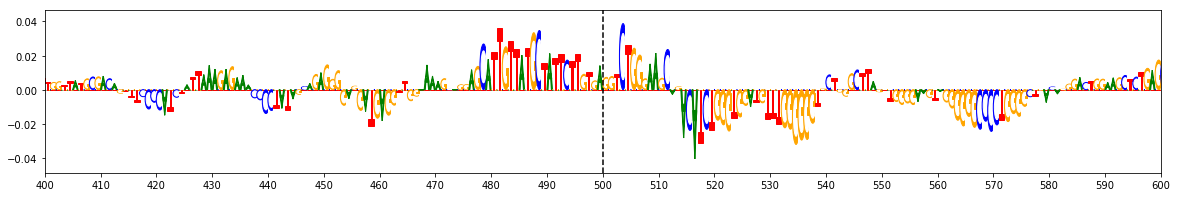

Noneffect Allele: G   ||  Explain Score: 0.4661   ||  Center / 200bp: 0.4939
Noneffect Sequence: ATTCTTGTGGGGTCTGGGAA


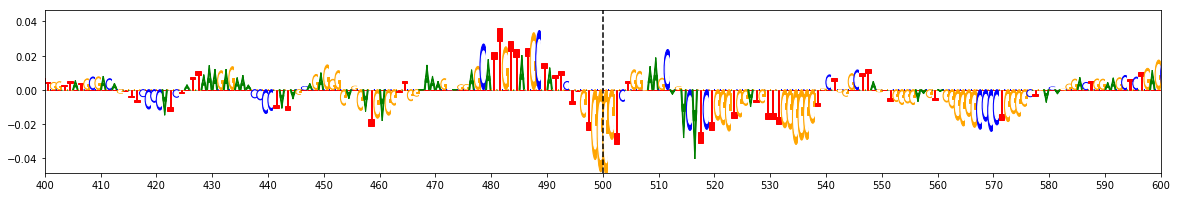

Allele Ratio : 1.5003   ||   Allele Difference : 0.4897  ||  ISM Score : 0.7651  ||  deltaSVM Score : 4.3909


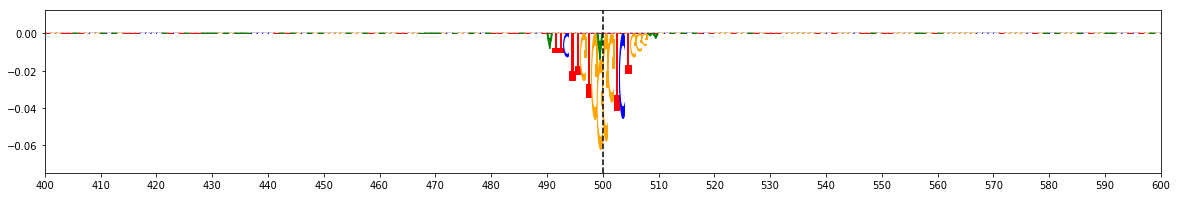


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs78826239   ||    chr17 : 46213483 - 46213484   ||    Locus: 202   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.10E-18

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6279   ||  Center / 200bp: 0.7173
Effect Sequence: TTTTTTTTTTTTTTTAGTAG


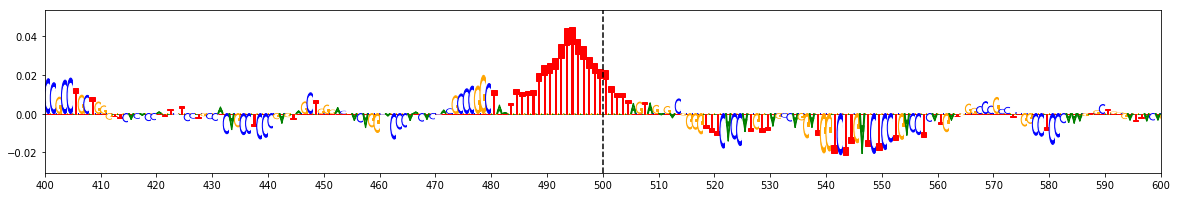

Noneffect Allele: A   ||  Explain Score: 0.528   ||  Center / 200bp: 0.6255
Noneffect Sequence: TTTTTTTTTATTTTTAGTAG


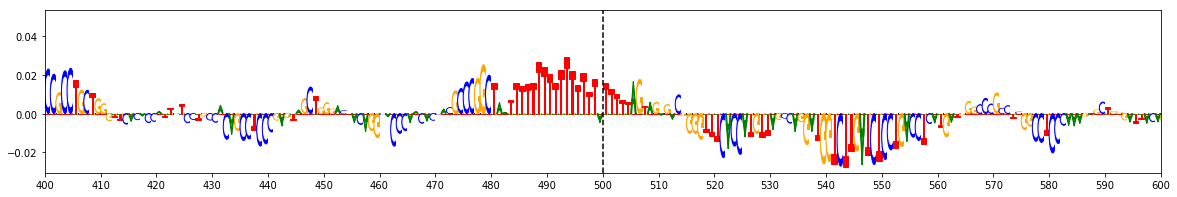

Allele Ratio : 1.1892   ||   Allele Difference : 0.1381  ||  ISM Score : 0.1195  ||  deltaSVM Score : 9.8663


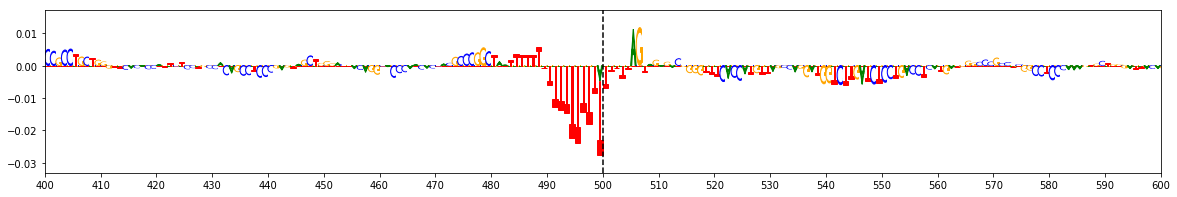


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17573509   ||    chr17 : 46003857 - 46003858   ||    Locus: 185   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.14E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.9616   ||  Center / 200bp: 0.5609
Effect Sequence: AATCTGTGTGAATCAAATCA


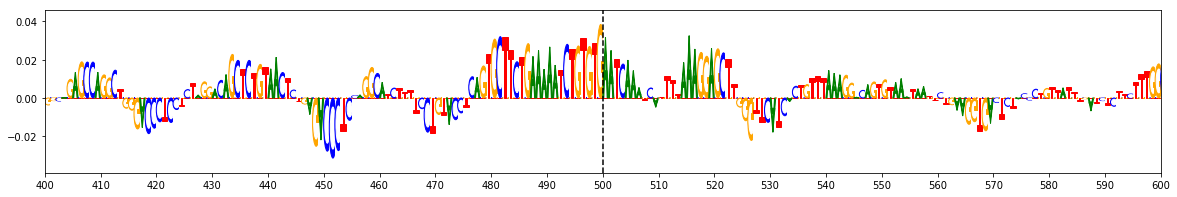

Noneffect Allele: A   ||  Explain Score: 0.6718   ||  Center / 200bp: 0.4722
Noneffect Sequence: AATCTGTGTAAATCAAATCA


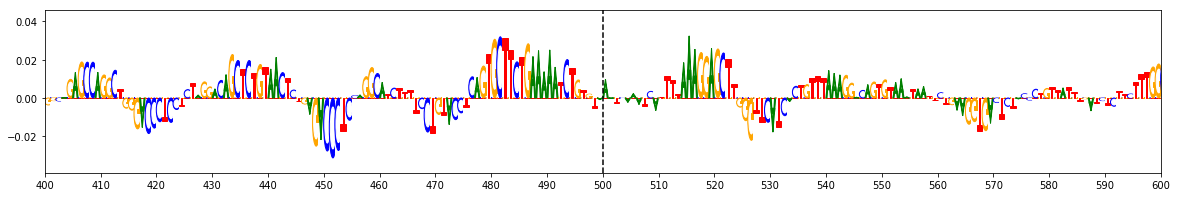

Allele Ratio : 1.4313   ||   Allele Difference : 0.3092  ||  ISM Score : 0.4802  ||  deltaSVM Score : 2.7437


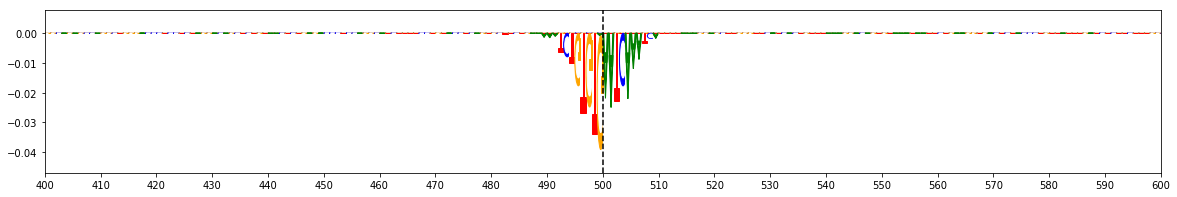


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10847864   ||    chr12 : 122842050 - 122842051   ||    Locus: 46   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  7.06E-14
Nalls_23andMe 		  7.06E-14

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.0362   ||  Center / 200bp: 0.481
Effect Sequence: CTGCTTTGCTTGTGGCCATA


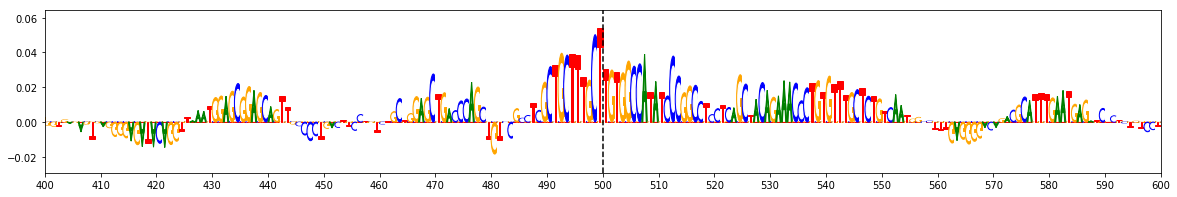

Noneffect Allele: G   ||  Explain Score: 0.6211   ||  Center / 200bp: 0.3572
Noneffect Sequence: CTGCTTTGCGTGTGGCCATA


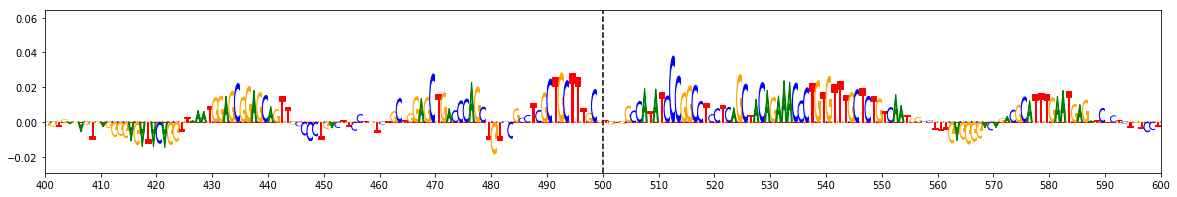

Allele Ratio : 1.6684   ||   Allele Difference : 0.4171  ||  ISM Score : 0.65  ||  deltaSVM Score : 3.7713


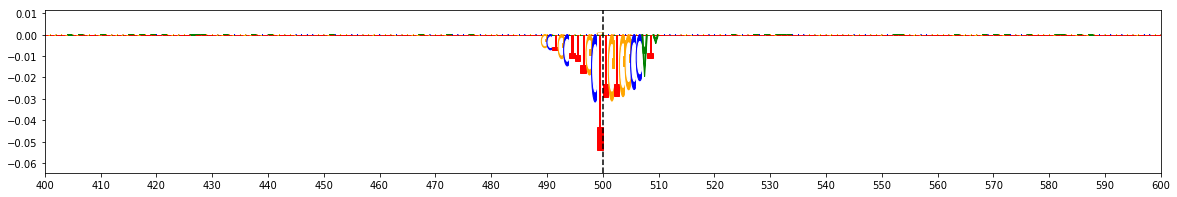


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2032915   ||    chr16 : 31106091 - 31106092   ||    Locus: 74   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.22E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.1922   ||  Center / 200bp: 0.6297
Effect Sequence: CTGGCTGTATTCCAGGACGT


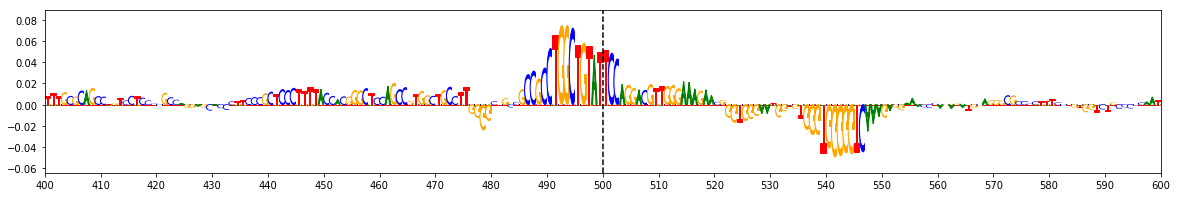

Noneffect Allele: C   ||  Explain Score: 0.9445   ||  Center / 200bp: 0.5741
Noneffect Sequence: CTGGCTGTACTCCAGGACGT


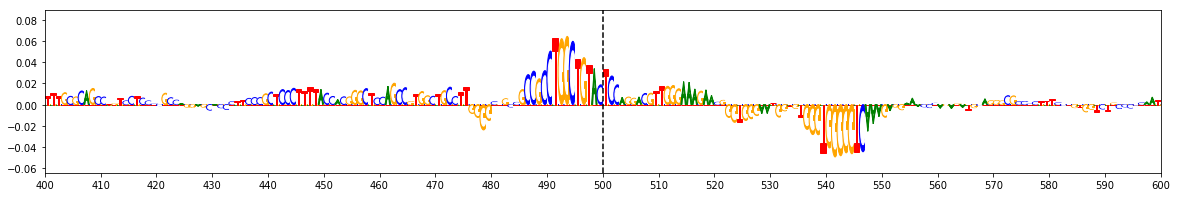

Allele Ratio : 1.2623   ||   Allele Difference : 0.2477  ||  ISM Score : 0.3896  ||  deltaSVM Score : 2.2518


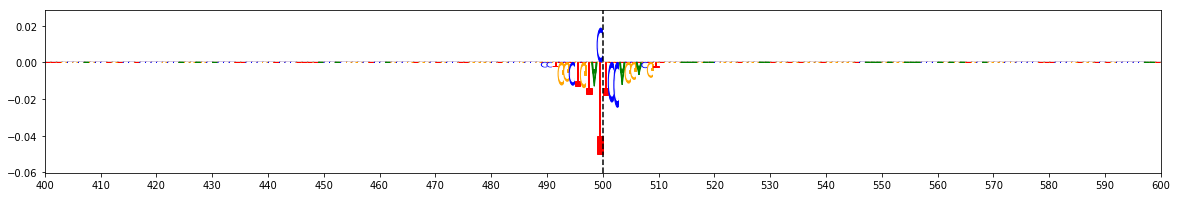


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs143560707   ||    chr15 : 64453059 - 64453060   ||    Locus: 62   ||    IDR Peak: True

GWAS:
Alzheimers_Lambert_2013 	  3.03E-06

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.578   ||  Center / 200bp: 0.5257
Effect Sequence: TGGCACACAGCTGTAGTCCC


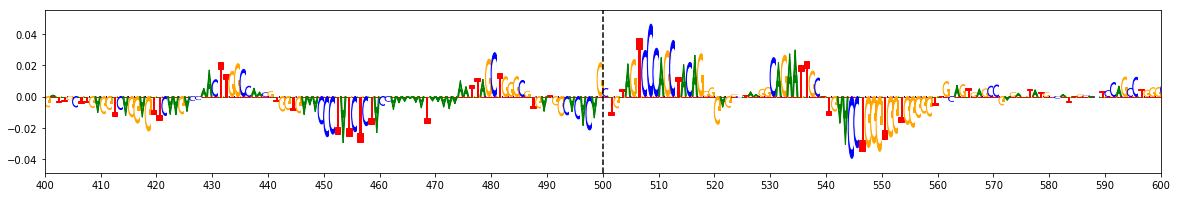

Noneffect Allele: C   ||  Explain Score: 0.3832   ||  Center / 200bp: 0.4239
Noneffect Sequence: TGGCACACACCTGTAGTCCC


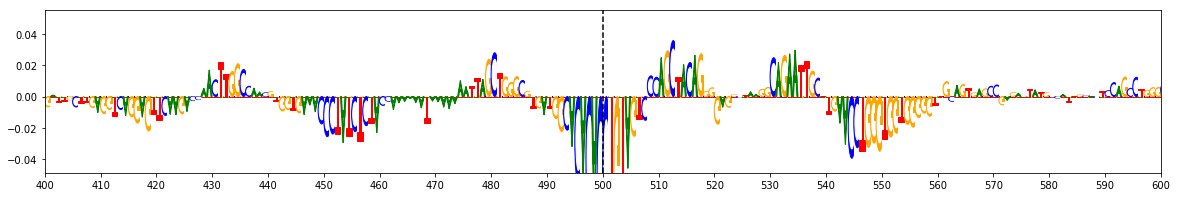

Allele Ratio : 1.5084   ||   Allele Difference : 1.0142  ||  ISM Score : 1.5915  ||  deltaSVM Score : 9.1905


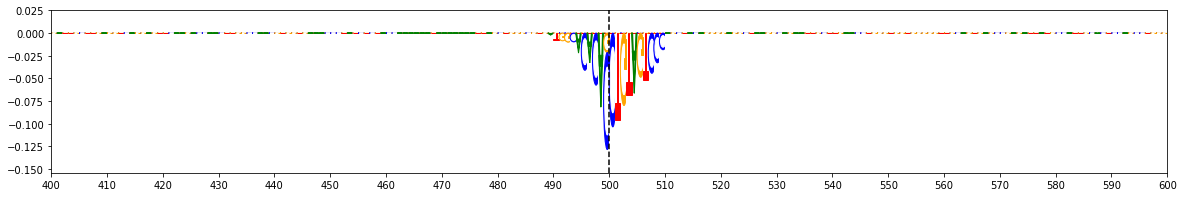


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55668363   ||    chr17 : 45815421 - 45815422   ||    Locus: 109   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.99E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.0836   ||  Center / 200bp: 0.7354
Effect Sequence: CTCTCTCGCGTGCTCTCTCT


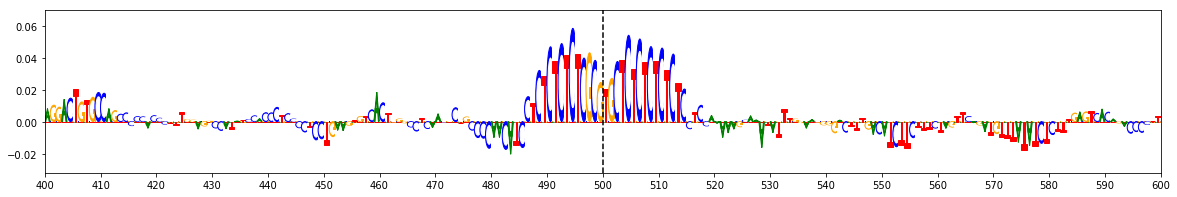

Noneffect Allele: A   ||  Explain Score: 1.0305   ||  Center / 200bp: 0.7256
Noneffect Sequence: CTCTCTCGCATGCTCTCTCT


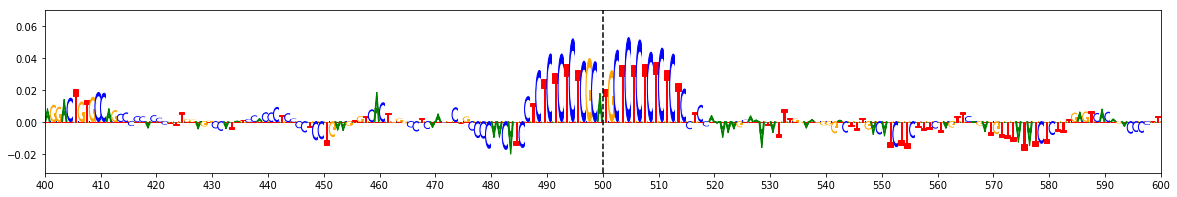

Allele Ratio : 1.0515   ||   Allele Difference : 0.053  ||  ISM Score : 0.0764  ||  deltaSVM Score : 0.5438


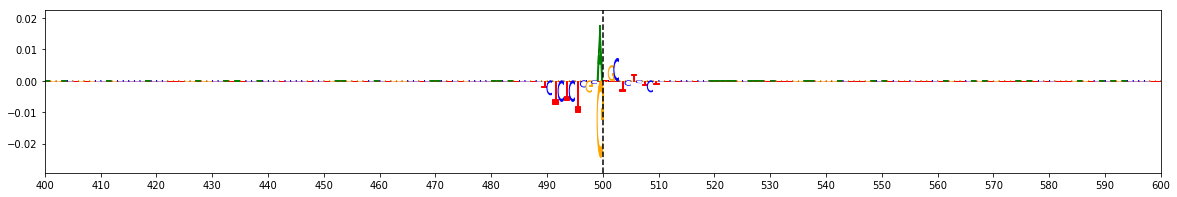


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062772   ||    chr17 : 45942947 - 45942948   ||    Locus: 148   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.65E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.3311   ||  Center / 200bp: 0.7363
Effect Sequence: GACTCCCTGTACTGCGCTGT


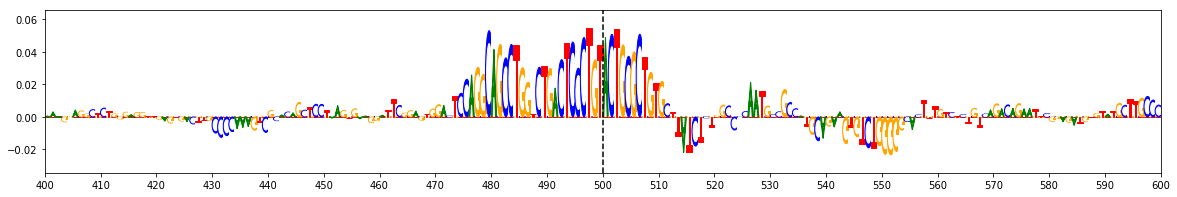

Noneffect Allele: C   ||  Explain Score: 1.2697   ||  Center / 200bp: 0.7279
Noneffect Sequence: GACTCCCTGCACTGCGCTGT


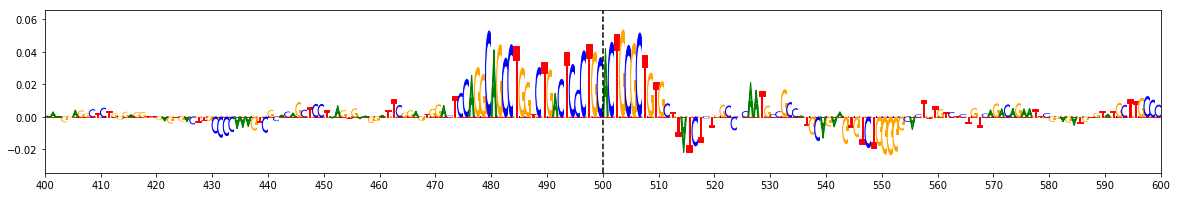

Allele Ratio : 1.0484   ||   Allele Difference : 0.061  ||  ISM Score : 0.099  ||  deltaSVM Score : 0.5289


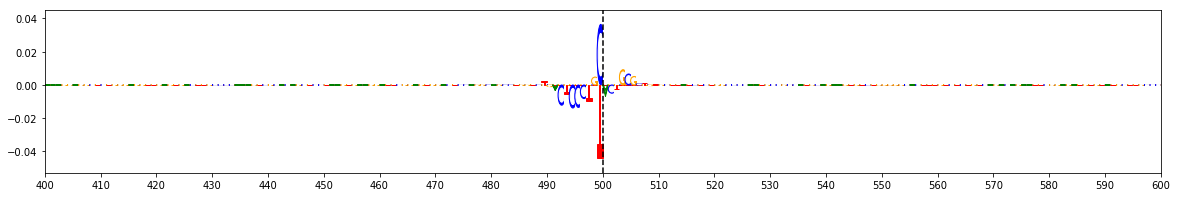


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs112950348   ||    chr17 : 45955821 - 45955822   ||    Locus: 166   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.19E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.5884   ||  Center / 200bp: 0.3513
Effect Sequence: GCAACCTCCGCCTCCTAGGT


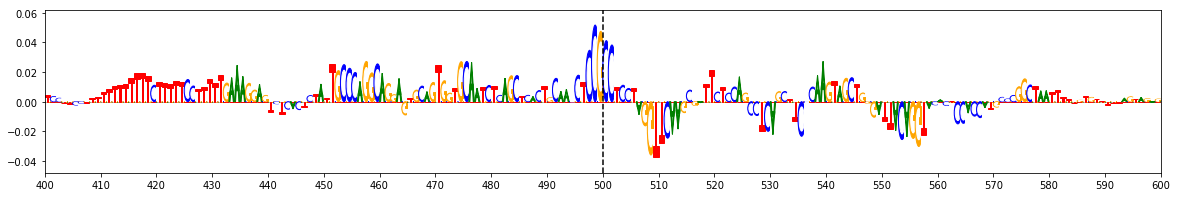

Noneffect Allele: A   ||  Explain Score: 0.2713   ||  Center / 200bp: 0.1996
Noneffect Sequence: GCAACCTCCACCTCCTAGGT


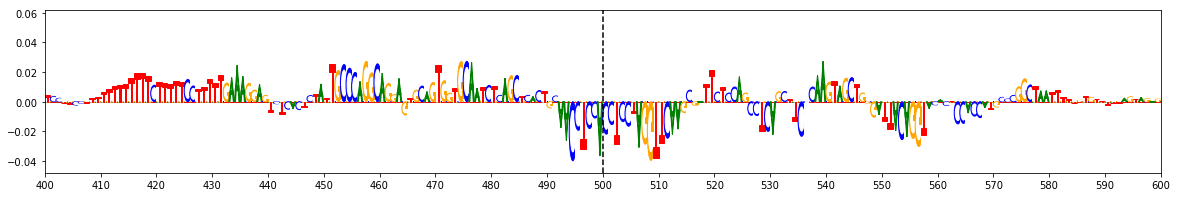

Allele Ratio : 2.1685   ||   Allele Difference : 0.6647  ||  ISM Score : 1.0586  ||  deltaSVM Score : 6.1198


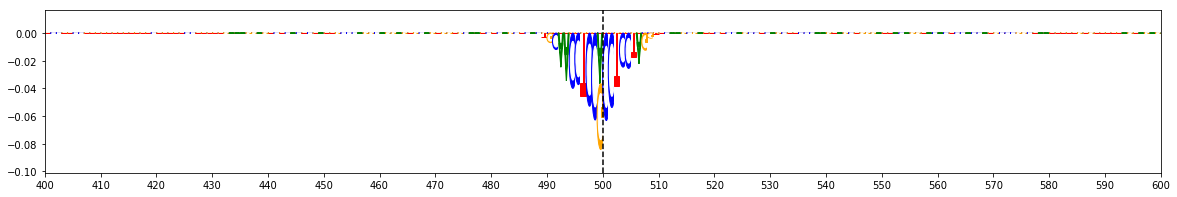


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17046072   ||    chr4 : 113453656 - 113453657   ||    Locus: 408   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  7.35E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.4171   ||  Center / 200bp: 0.6273
Effect Sequence: ATTTCACTTTTATTCTTTTC


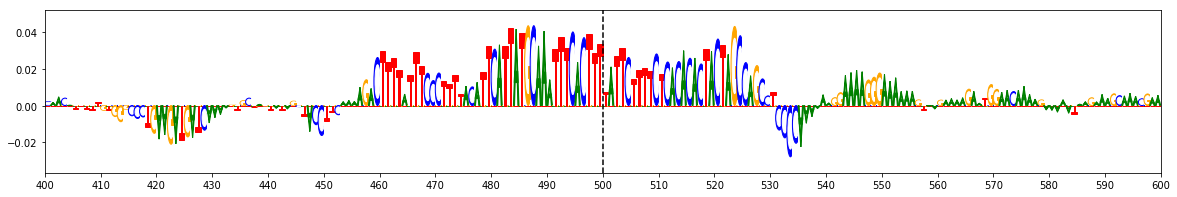

Noneffect Allele: C   ||  Explain Score: 1.1672   ||  Center / 200bp: 0.5794
Noneffect Sequence: ATTTCACTTCTATTCTTTTC


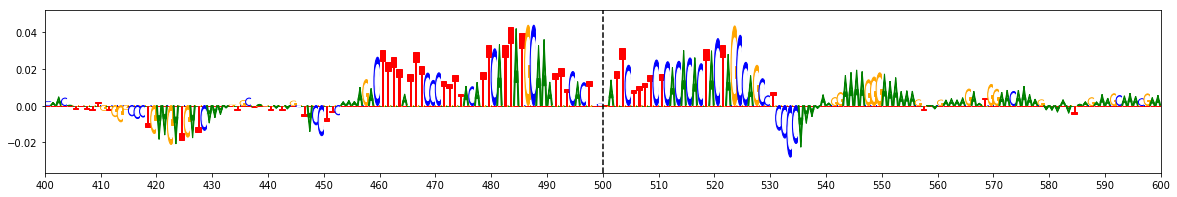

Allele Ratio : 1.2141   ||   Allele Difference : 0.2501  ||  ISM Score : 0.4219  ||  deltaSVM Score : 2.4646


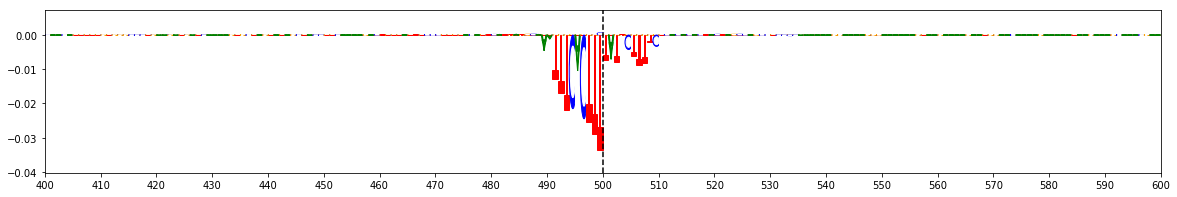


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs142135910   ||    chr3 : 52300359 - 52300360   ||    Locus: 366   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  9.93E-04

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.8186   ||  Center / 200bp: 0.6208
Effect Sequence: TATTTGGAGCGTAGGAGAAG


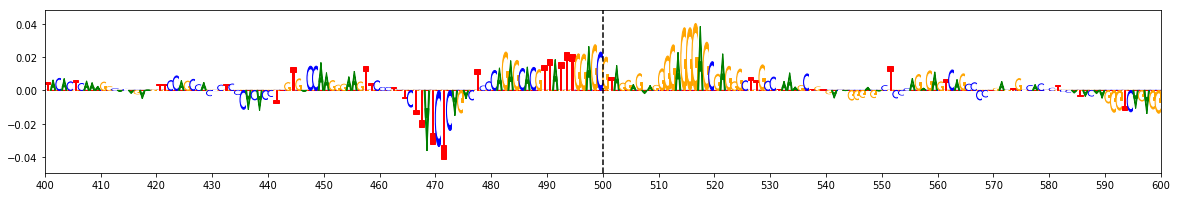

Noneffect Allele: A   ||  Explain Score: 0.6824   ||  Center / 200bp: 0.5773
Noneffect Sequence: TATTTGGAGAGTAGGAGAAG


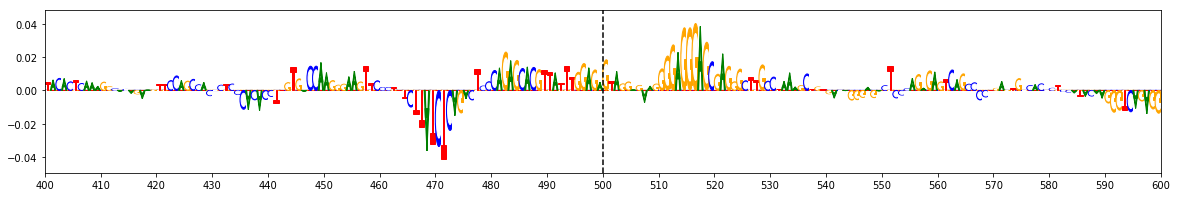

Allele Ratio : 1.1996   ||   Allele Difference : 0.1416  ||  ISM Score : 0.2261  ||  deltaSVM Score : 1.3402


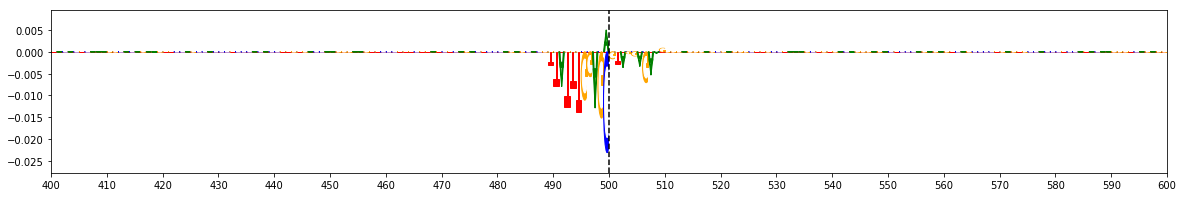


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()